# 📊 EDA - Datasets FAO (Réels)

**Objectif :** Analyser et nettoyer les 5 datasets FAO pour préparer la fusion

**Datasets :**
1. `df_rendements_fao` - Rendements historiques (1961-2016)
2. `df_rendements_agro` - Rendements avec facteurs climatiques (1990-2013)
3. `df_pesticides` - Usage de pesticides
4. `df_rainfall` - Précipitations
5. `df_temp` - Températures

---
# 1. Imports et Configuration

In [1]:
import pandas as pd
import sys
from pathlib import Path
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from config.paths import DONNEES_AGRO_CLIMATIQUES
from config.config import RANDOM_STATE

In [2]:
# Créer dossier de sortie pour datasets nettoyés
OUTPUT_DIR = DONNEES_AGRO_CLIMATIQUES / "clean"
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"📁 Dossier de sortie : {OUTPUT_DIR}")

📁 Dossier de sortie : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean


---
# 2. DATASET 1 : df_rendements_fao

**Source :** `yield.csv` - Rendements historiques FAO (1961-2016)

## 2.1 Chargement et Vue d'ensemble

In [3]:
df_rendements_fao = pd.read_csv(DONNEES_AGRO_CLIMATIQUES / "yield.csv")
print(f"Shape : {df_rendements_fao.shape}")
df_rendements_fao.head()

Shape : (56717, 12)


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [4]:
df_rendements_fao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Area Code     56717 non-null  int64 
 3   Area          56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB


Valeurs manquantes :
Domain Code     0
Domain          0
Area Code       0
Area            0
Element Code    0
Element         0
Item Code       0
Item            0
Year Code       0
Year            0
Unit            0
Value           0
dtype: int64


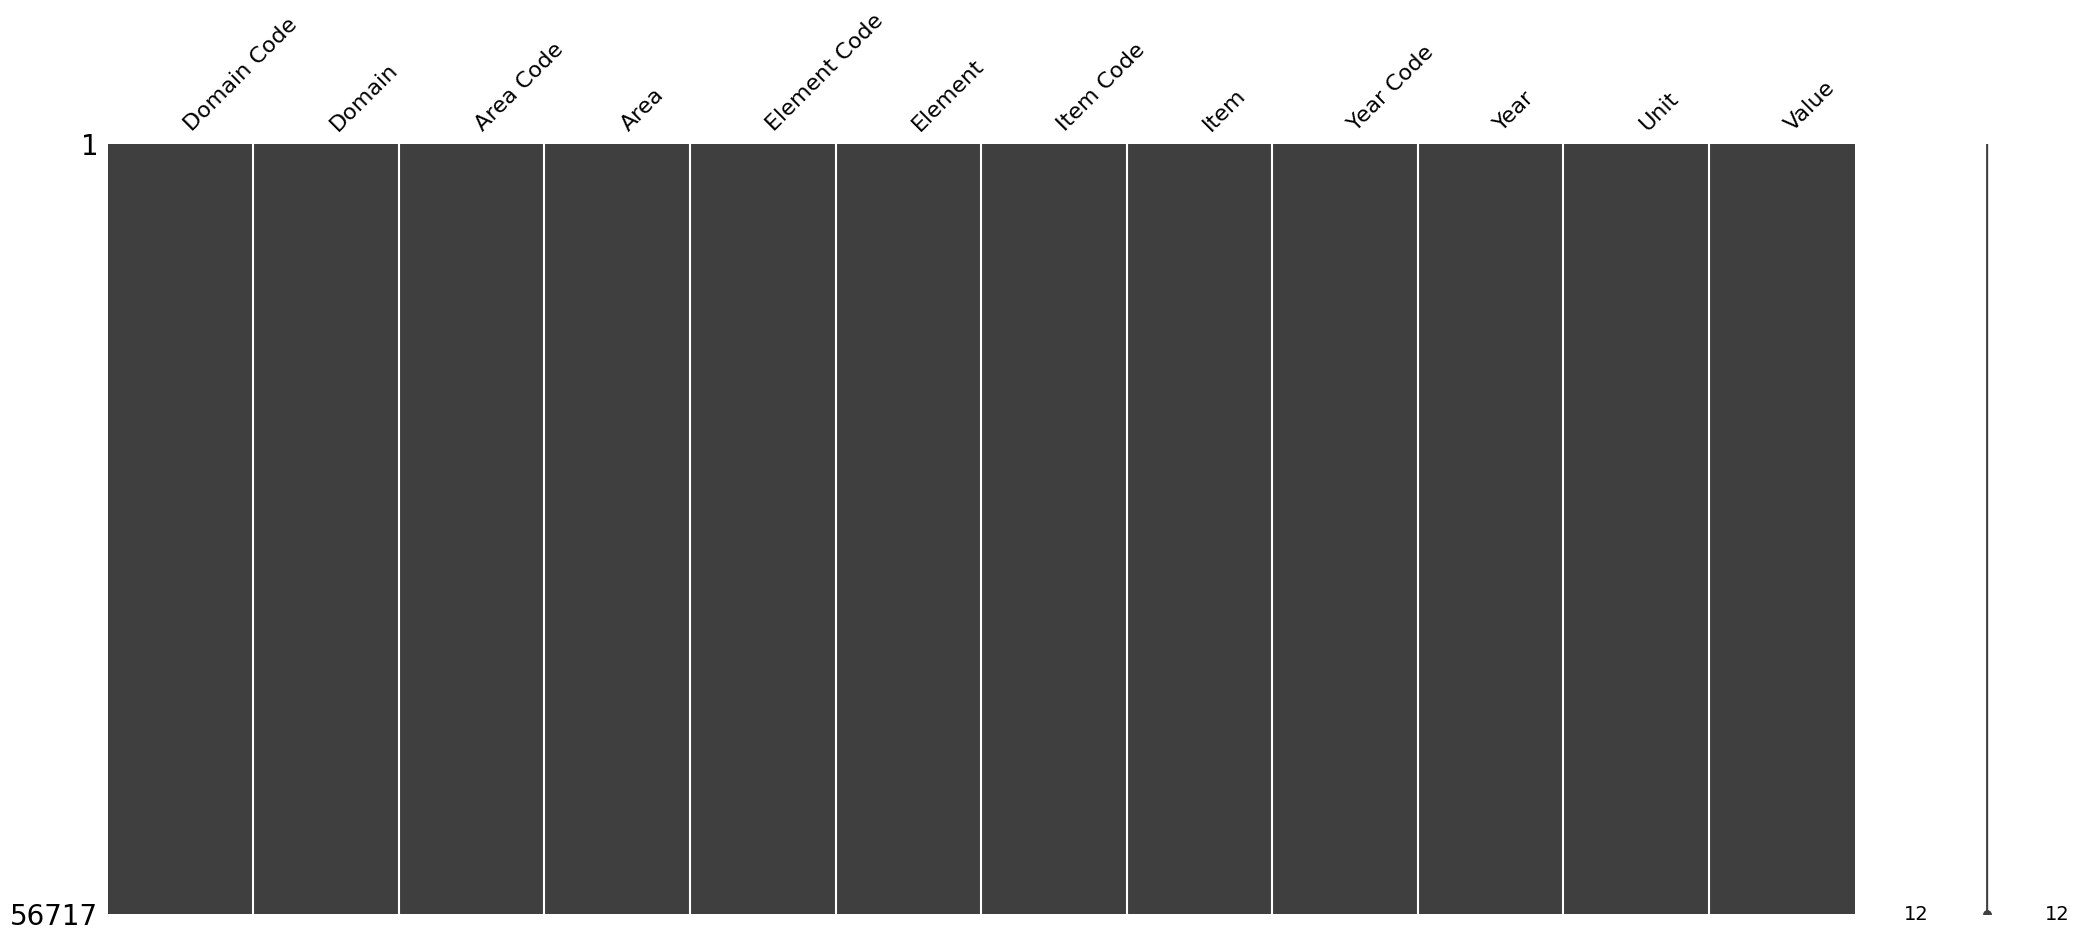

In [5]:
# Valeurs manquantes
print("Valeurs manquantes :")
print(df_rendements_fao.isnull().sum())
msno.matrix(df_rendements_fao)
plt.show()

**✅ Aucune valeur manquante**

## 2.2 Nettoyage des colonnes

In [6]:
# Identifier les colonnes à valeur unique (inutiles)
print("Colonnes à valeur unique :")
for col in df_rendements_fao.columns:
    n_unique = df_rendements_fao[col].nunique()
    if n_unique == 1:
        print(f"  - {col} : {df_rendements_fao[col].unique()[0]}")

Colonnes à valeur unique :
  - Domain Code : QC
  - Domain : Crops
  - Element Code : 5419
  - Element : Yield
  - Unit : hg/ha


In [7]:
# Vérifier Year Code = Year (redondance)
print("Year Code == Year ?")
print((df_rendements_fao['Year Code'] == df_rendements_fao['Year']).all())

Year Code == Year ?
True


In [8]:
# Suppression des colonnes inutiles
colonnes_a_supprimer = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Year Code', 'Unit']

print(f"Avant suppression : {df_rendements_fao.shape}")
df_rendements_fao.drop(columns=colonnes_a_supprimer, inplace=True)
print(f"Après suppression : {df_rendements_fao.shape}")

Avant suppression : (56717, 12)
Après suppression : (56717, 6)


In [9]:
# Renommer Value → yield_hg_per_ha (clarté)
df_rendements_fao.rename(columns={'Value': 'yield_hg_per_ha'}, inplace=True)
print("Colonnes après renommage :")
print(df_rendements_fao.columns.tolist())

Colonnes après renommage :
['Area Code', 'Area', 'Item Code', 'Item', 'Year', 'yield_hg_per_ha']


## 2.3 Nettoyage des valeurs

In [10]:
# Vérifier les valeurs à 0
nb_zeros = (df_rendements_fao['yield_hg_per_ha'] == 0).sum()
print(f"Nombre de rendements à 0 : {nb_zeros}")

if nb_zeros > 0:
    print("\nExemples :")
    print(df_rendements_fao[df_rendements_fao['yield_hg_per_ha'] == 0].head())

Nombre de rendements à 0 : 8

Exemples :
       Area Code           Area  Item Code     Item  Year  yield_hg_per_ha
35804        153  New Caledonia         83  Sorghum  2000                0
35806        153  New Caledonia         83  Sorghum  2012                0
35906        153  New Caledonia         15    Wheat  2000                0
35908        153  New Caledonia         15    Wheat  2002                0
35912        153  New Caledonia         15    Wheat  2006                0


In [11]:
# Suppression des valeurs à 0 (rendement nul = anomalie)
print(f"Shape avant suppression valeurs 0 : {df_rendements_fao.shape}")
df_rendements_fao = df_rendements_fao[df_rendements_fao['yield_hg_per_ha'] > 0].copy()
print(f"Shape après suppression valeurs 0 : {df_rendements_fao.shape}")

Shape avant suppression valeurs 0 : (56717, 6)
Shape après suppression valeurs 0 : (56709, 6)


## 2.4 Analyse des outliers

In [12]:
# Statistiques outliers
Q1 = df_rendements_fao['yield_hg_per_ha'].quantile(0.25)
Q3 = df_rendements_fao['yield_hg_per_ha'].quantile(0.75)
IQR = Q3 - Q1
outlier_high = Q3 + 1.5 * IQR

nb_outliers = (df_rendements_fao['yield_hg_per_ha'] > outlier_high).sum()

print(f"Q1 (25%) : {Q1:.2f}")
print(f"Q3 (75%) : {Q3:.2f}")
print(f"IQR : {IQR:.2f}")
print(f"Limite haute outliers : {outlier_high:.2f}")
print(f"Nombre d'outliers hauts : {nb_outliers} ({nb_outliers/len(df_rendements_fao)*100:.2f}%)")

Q1 (25%) : 15691.00
Q3 (75%) : 86232.00
IQR : 70541.00
Limite haute outliers : 192043.50
Nombre d'outliers hauts : 3168 (5.59%)


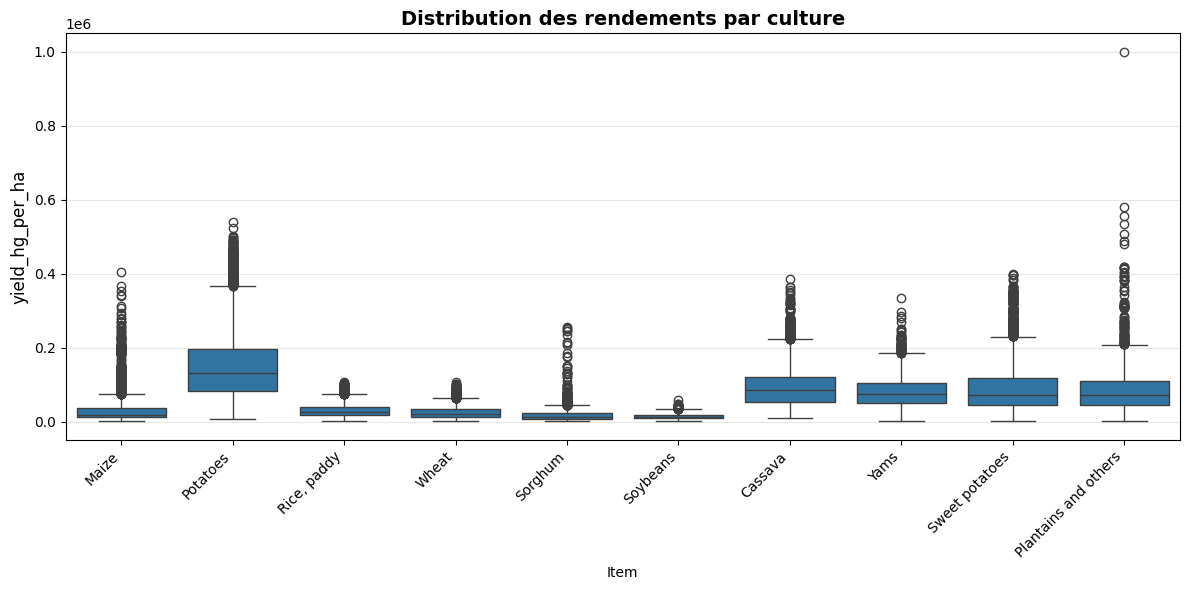

In [13]:
# Boxplot PAR CULTURE (essentiel pour données agricoles)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_rendements_fao, x='Item', y='yield_hg_per_ha')
plt.xticks(rotation=45, ha='right')
plt.ylabel('yield_hg_per_ha', fontsize=12)
plt.title('Distribution des rendements par culture', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Identifier l'outlier extrême (1,000,000)
outlier_extreme = df_rendements_fao[df_rendements_fao['yield_hg_per_ha'] == 1000000]
print("Outlier extrême à 1,000,000 hg/ha :")
print(outlier_extreme[['Area', 'Item', 'Year', 'yield_hg_per_ha']])

Outlier extrême à 1,000,000 hg/ha :
        Area                  Item  Year  yield_hg_per_ha
27930  Kenya  Plantains and others  1964          1000000


In [15]:
# Suppression de l'outlier extrême (erreur de saisie probable)
print(f"Shape avant suppression outlier extrême : {df_rendements_fao.shape}")
df_rendements_fao = df_rendements_fao[df_rendements_fao['yield_hg_per_ha'] < 1000000].copy()
print(f"Shape après suppression outlier extrême : {df_rendements_fao.shape}")

Shape avant suppression outlier extrême : (56709, 6)
Shape après suppression outlier extrême : (56708, 6)


In [16]:
# RÈGLE STRICTE : 3*IQR (au lieu de 1.5*IQR)
# = Supprimer UNIQUEMENT les outliers EXTRÊMES

for culture in df_rendements_fao['Item'].unique():
    df_culture = df_rendements_fao[df_rendements_fao['Item'] == culture]
    
    Q1 = df_culture['yield_hg_per_ha'].quantile(0.25)
    Q3 = df_culture['yield_hg_per_ha'].quantile(0.75)
    IQR = Q3 - Q1
    
    # SEUIL STRICT
    limite_haute = Q3 + 3 * IQR  # Au lieu de 1.5
    
    # Supprimer UNIQUEMENT au-delà de 3*IQR
    outliers_extremes = df_culture[df_culture['yield_hg_per_ha'] > limite_haute]
    
    print(f"{culture} : {len(outliers_extremes)} outliers supprimés (> {limite_haute:.0f})")

Maize : 190 outliers supprimés (> 113744)
Potatoes : 1 outliers supprimés (> 537478)
Rice, paddy : 0 outliers supprimés (> 109510)
Wheat : 9 outliers supprimés (> 94507)
Sorghum : 60 outliers supprimés (> 66077)
Soybeans : 1 outliers supprimés (> 50025)
Cassava : 10 outliers supprimés (> 324915)
Yams : 5 outliers supprimés (> 265406)
Sweet potatoes : 36 outliers supprimés (> 341921)
Plantains and others : 45 outliers supprimés (> 305728)


In [17]:
# Pour chaque culture, inspecter les TOP 10 outliers
for culture in ['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat', 
                'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams']:
    top10 = df_rendements_fao[df_rendements_fao['Item'] == culture].nlargest(10, 'yield_hg_per_ha')
    print(f"\n{culture} - TOP 10 :")
    print(top10[['Area', 'Year', 'yield_hg_per_ha']])
    
    # Question : Belgique Potatoes 500K = normal ?
    # → Vérifier avec sources externes (FAO website)


Maize - TOP 10 :
                       Area  Year  yield_hg_per_ha
27506                Jordan  2016           404127
52500  United Arab Emirates  2013           367619
52502  United Arab Emirates  2015           352913
26040                Israel  2014           340977
26037                Israel  2011           338158
28359                Kuwait  2013           311478
28360                Kuwait  2014           307532
26036                Israel  2010           292355
27492                Jordan  2002           286750
27505                Jordan  2015           280447

Potatoes - TOP 10 :
                           Area  Year  yield_hg_per_ha
3660                    Belgium  2014           540003
3755         Belgium-Luxembourg  1997           522291
3657                    Belgium  2011           501412
3751         Belgium-Luxembourg  1993           499376
36080               New Zealand  2010           495751
36081               New Zealand  2011           490361
53380  United S

**Notes sur les Outliers conservés**
- Des pays comme la Belgique (patates et frites) pratiquent une agriculture intensive avérée
- Une suppression trop systématique pourrait entraîner une perte d'information sur les pratiques optimales

## 2.5 Informations clés

In [18]:
print("=" * 50)
print("INFORMATIONS CLÉS - df_rendements_fao")
print("=" * 50)
print(f"Nombre de pays : {df_rendements_fao['Area'].nunique()}")
print(f"Nombre de cultures : {df_rendements_fao['Item'].nunique()}")
print(f"Cultures : {df_rendements_fao['Item'].unique().tolist()}")
print(f"Période : {df_rendements_fao['Year'].min()} - {df_rendements_fao['Year'].max()}")
print(f"Shape finale : {df_rendements_fao.shape}")

INFORMATIONS CLÉS - df_rendements_fao
Nombre de pays : 212
Nombre de cultures : 10
Cultures : ['Maize', 'Potatoes', 'Rice, paddy', 'Wheat', 'Sorghum', 'Soybeans', 'Cassava', 'Yams', 'Sweet potatoes', 'Plantains and others']
Période : 1961 - 2016
Shape finale : (56708, 6)


## 2.6 Sauvegarde

## ✅ Conclusion df_rendements_fao

**Nettoyages effectués :**
- ✅ Suppression de 6 colonnes inutiles (Domain Code, Domain, Element Code, Element, Year Code, Unit)
- ✅ Renommage Value → yield_hg_per_ha
- ✅ Suppression de 8 valeurs à 0
- ✅ Suppression de 1 outlier extrême (1,000,000 hg/ha)

**Dataset final :**
- 56,708 lignes, 6 colonnes
- 212 pays, 10 cultures
- Période : 1961-2016
- Clés de jointure : **Area Code, Area, Item Code, Item, Year**

## Création de la table de correspondance Area <-> Area_code

In [19]:
# Extraire les paires uniques depuis df_rendements_fao
area_mapping = df_rendements_fao[['Area', 'Area Code']].drop_duplicates().copy()
area_mapping = area_mapping.rename(columns={'Area Code': 'Area_Code'})
area_mapping = area_mapping.sort_values('Area').reset_index(drop=True)

print(area_mapping.head(10))

                  Area  Area_Code
0          Afghanistan          2
1              Albania          3
2              Algeria          4
3       American Samoa          5
4               Angola          7
5  Antigua and Barbuda          8
6            Argentina          9
7              Armenia          1
8            Australia         10
9              Austria         11


In [20]:
# Identifier les variations potentielles (ex: Belgium vs Belgium-Luxembourg)
area_variations = area_mapping[area_mapping['Area'].str.contains('-', na=False)]
if len(area_variations) > 0:
    print(f"\n⚠️ Attention : {len(area_variations)} noms avec tirets détectés :")
    print(area_variations[['Area', 'Area_Code']].to_string(index=False))

# Sauvegarder la table de correspondance
mapping_path = OUTPUT_DIR / 'area_code_mapping.csv'
area_mapping.to_csv(mapping_path, index=False)
print(f"\n✅ Table sauvegardée : {mapping_path}")


⚠️ Attention : 3 noms avec tirets détectés :
              Area  Area_Code
Belgium-Luxembourg         15
     Guinea-Bissau        175
       Timor-Leste        176

✅ Table sauvegardée : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean\area_code_mapping.csv


In [21]:
df_rendements_fao = df_rendements_fao.rename(columns={'Area Code': 'Area_Code'})

In [22]:
df_rendements_fao.columns

Index(['Area_Code', 'Area', 'Item Code', 'Item', 'Year', 'yield_hg_per_ha'], dtype='object')

In [23]:
output_path = OUTPUT_DIR / "rendements_fao_clean.csv"
df_rendements_fao.to_csv(output_path, index=False)
print(f"✅ Dataset nettoyé sauvegardé : {output_path}")
print(f"Shape final : {df_rendements_fao.shape}")

✅ Dataset nettoyé sauvegardé : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean\rendements_fao_clean.csv
Shape final : (56708, 6)


## Création d'un dictionnaire de correspondances de noms de pays
*Mapping des variantes connues vers les noms FAO officiels.*

In [24]:
# Dictionnaire de correspondance manuelle
manual_mapping = {
    # Variantes d'apostrophes/accents
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Côte D'Ivoire": "Côte d'Ivoire",
    
    # Variantes de noms complets
    "United States": "United States of America",
    "Russia": "Russian Federation",
    "Iran": "Iran (Islamic Republic of)",
    "Venezuela": "Venezuela (Bolivarian Republic of)",
    "Bolivia": "Bolivia (Plurinational State of)",
    "Vietnam": "Viet Nam",
    "Taiwan": "China, Taiwan Province of",
    "Moldova": "Republic of Moldova",
    "Czech Republic": "Czechia",
    
    # Variantes Congo
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Congo (Democratic Republic Of The)": "Democratic Republic of the Congo",
    "Congo, Rep.": "Congo",
    
    # Territoires spéciaux (à vérifier si dans FAO)
    "China, Macao SAR": "China, Macao Special Administrative Region",

    # AJOUTS SPÉCIFIQUES df_temp
    "Syria": "Syrian Arab Republic",
    "Laos": "Lao People's Democratic Republic",
    "South Korea": "Republic of Korea",
    "Tanzania": "United Republic of Tanzania",
    "Bosnia And Herzegovina": "Bosnia and Herzegovina",
    "Macedonia": "North Macedonia",
    "Guinea Bissau": "Guinea-Bissau",
    "Hong Kong": "China, Hong Kong Special Administrative Region"
}

---
# 3. DATASET 2 : df_rendements_agro

**Source :** `yield_df.csv` - Rendements avec facteurs climatiques (1990-2013)

## 3.1 Chargement et Vue d'ensemble

In [25]:
df_rendements_agro = pd.read_csv(DONNEES_AGRO_CLIMATIQUES / "yield_df.csv")
print(f"Shape : {df_rendements_agro.shape}")
df_rendements_agro.head()

Shape : (28242, 8)


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [26]:
df_rendements_agro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


Valeurs manquantes :
Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64


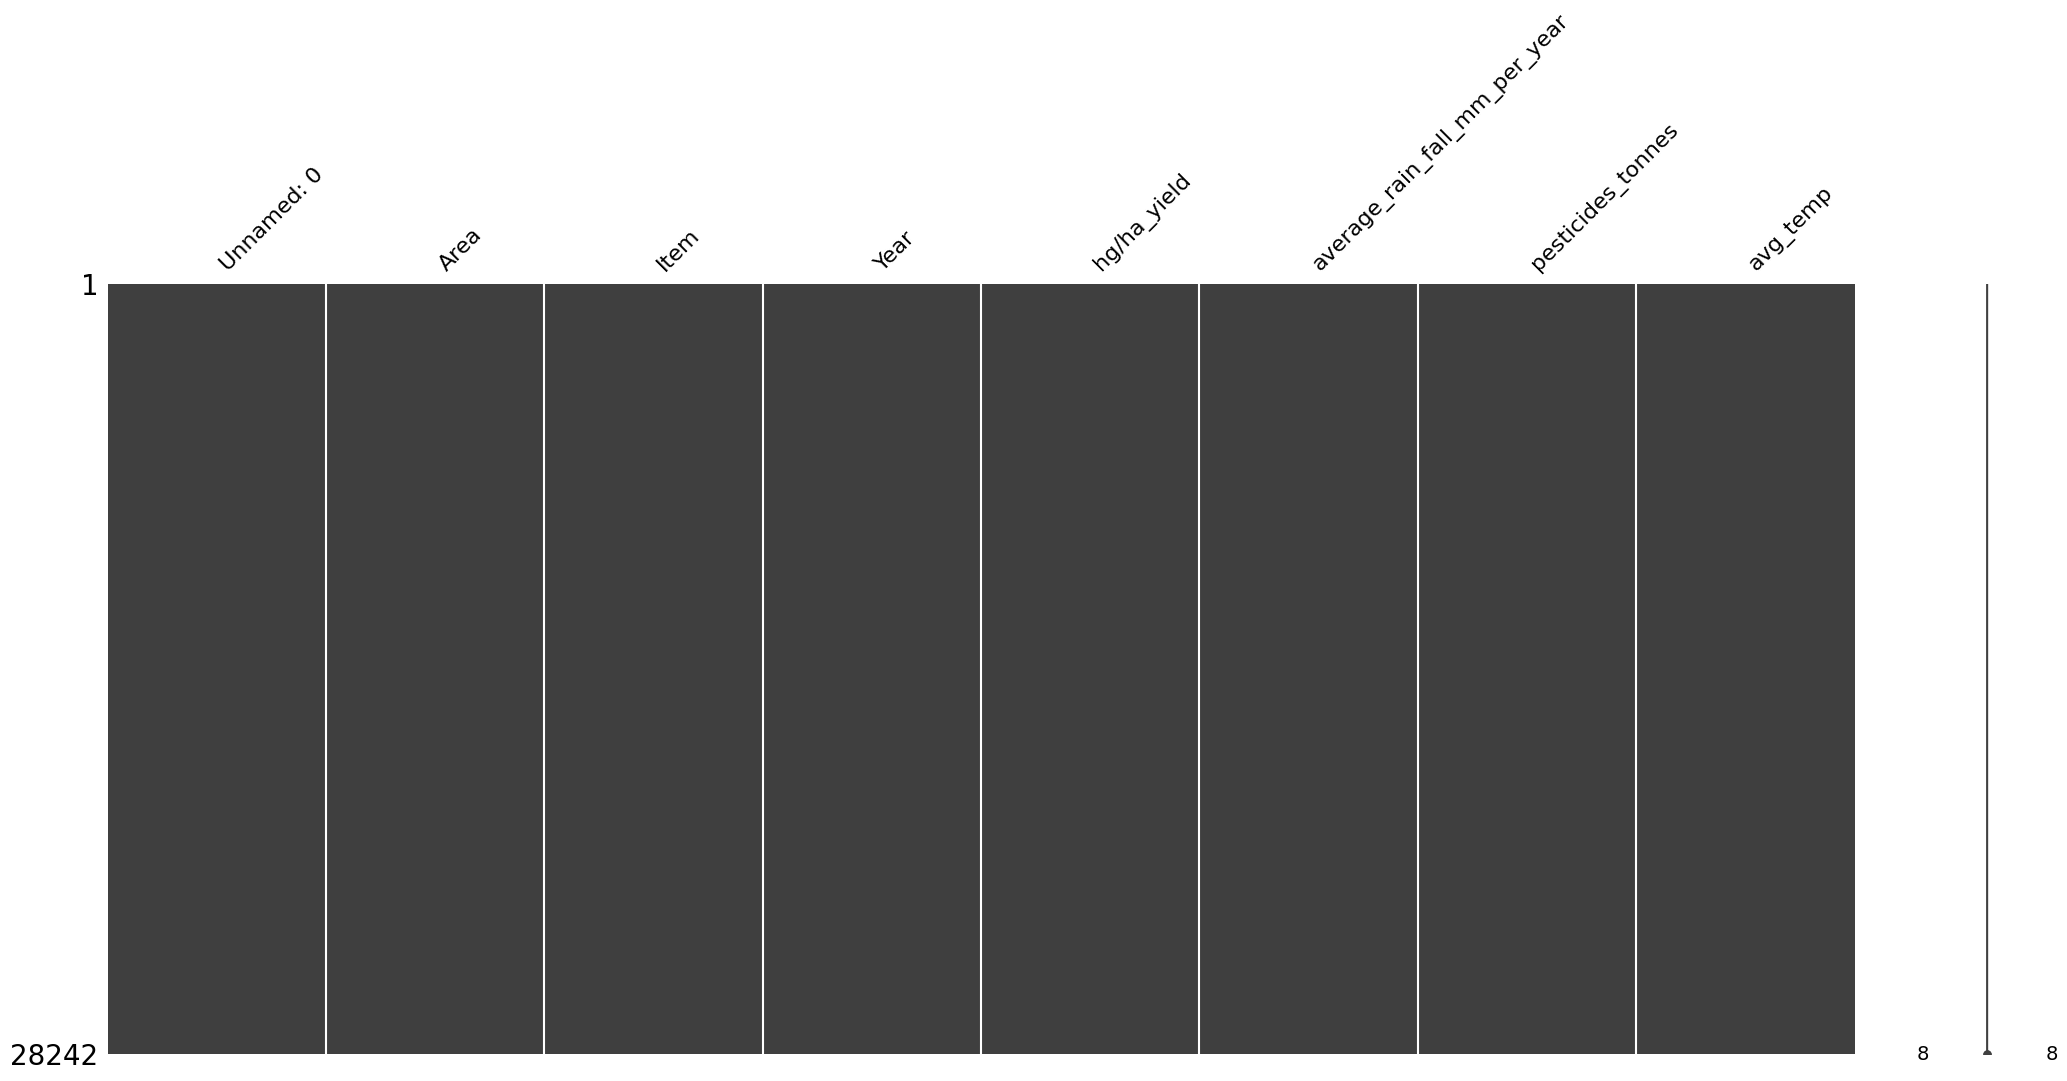

In [27]:
# Valeurs manquantes
print("Valeurs manquantes :")
print(df_rendements_agro.isnull().sum())
msno.matrix(df_rendements_agro)
plt.show()

**✅ Aucune valeur manquante**

In [28]:
# Standardisation nom colonne rendement
df_rendements_agro.rename(columns={'hg/ha_yield': 'yield_hg_per_ha'}, inplace=True)

## 3.2 Nettoyage des colonnes

In [29]:
# Suppression de la colonne d'index
print(f"Avant suppression : {df_rendements_agro.shape}")
df_rendements_agro.drop(columns=['Unnamed: 0'], inplace=True)
print(f"Après suppression : {df_rendements_agro.shape}")

Avant suppression : (28242, 8)
Après suppression : (28242, 7)


## Ajout de Area_Code via table de correspondance

In [30]:
# Standardisation des noms de pays AVANT jointure

In [31]:
# Afficher les pays uniques avant standardisation
print(f"Pays uniques avant : {df_rendements_agro['Area'].nunique()}")

# Appliquer la standardisation
df_rendements_agro['Area'] = df_rendements_agro['Area'].replace(manual_mapping)

# Afficher après
print(f"Pays uniques après : {df_rendements_agro['Area'].nunique()}")

Pays uniques avant : 101
Pays uniques après : 101


In [32]:
# Charger la table de correspondance
area_mapping = pd.read_csv(OUTPUT_DIR / 'area_code_mapping.csv')

# Fusionner pour ajouter Area_Code
shape_before = df_rendements_agro.shape
df_rendements_agro = df_rendements_agro.merge(
    area_mapping, 
    on='Area', 
    how='left'
)

print(f"Shape avant fusion : {shape_before}")
print(f"Shape après fusion : {df_rendements_agro.shape}")


Shape avant fusion : (28242, 7)
Shape après fusion : (28242, 8)


In [33]:
# Vérifier les pays sans correspondance
missing_area_code = df_rendements_agro[df_rendements_agro['Area_Code'].isna()]
if len(missing_area_code) > 0:
    print(f"\n⚠️ ATTENTION : {len(missing_area_code)} lignes sans Area_Code")
    print(f"Pays concernés :")
    print(missing_area_code['Area'].unique())
else:
    print("\n✅ Tous les pays ont un Area_Code correspondant")


✅ Tous les pays ont un Area_Code correspondant


In [34]:
# Réorganiser les colonnes (Area_Code après Area)
cols = df_rendements_agro.columns.tolist()
cols.remove('Area_Code')
idx_area = cols.index('Area')
cols.insert(idx_area + 1, 'Area_Code')
df_rendements_agro = df_rendements_agro[cols]

print(f"\nColonnes finales : {df_rendements_agro.columns.tolist()}")


Colonnes finales : ['Area', 'Area_Code', 'Item', 'Year', 'yield_hg_per_ha', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


## 3.3 Analyse des outliers (PAR CULTURE)

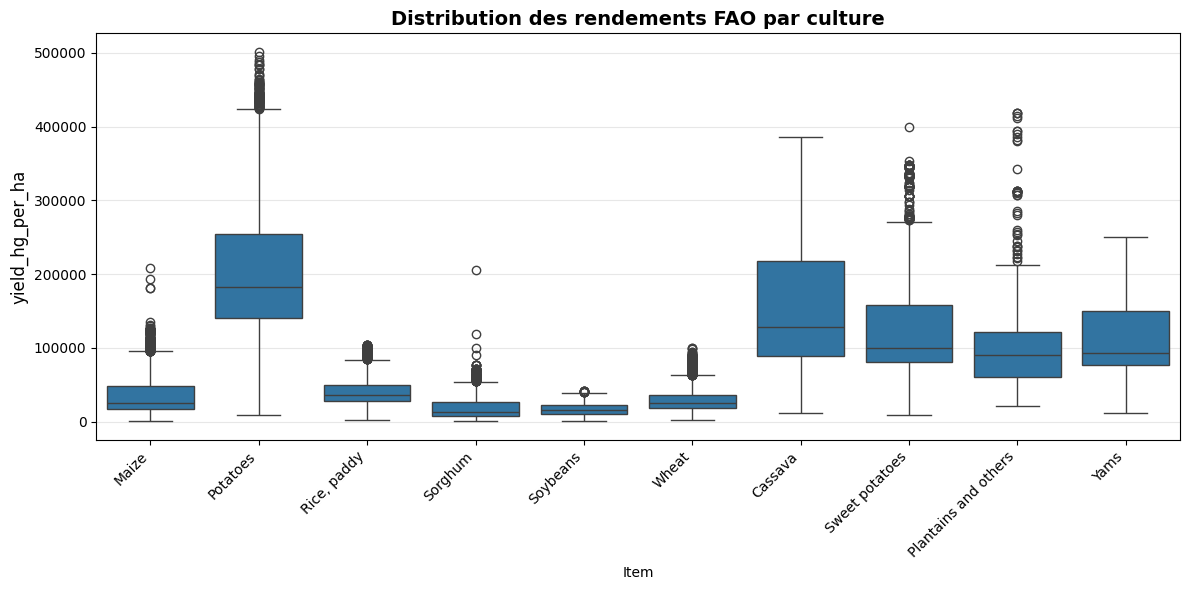

In [35]:
# Boxplot PAR CULTURE (essentiel pour données agricoles)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_rendements_agro, x='Item', y='yield_hg_per_ha')
plt.xticks(rotation=45, ha='right')
plt.ylabel('yield_hg_per_ha', fontsize=12)
plt.title('Distribution des rendements FAO par culture', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Observation :** Les rendements varient énormément selon les cultures (Potatoes ~300K vs Sorghum ~15K).

In [36]:
# RÈGLE STRICTE : 3*IQR (au lieu de 1.5*IQR)
# = Supprimer UNIQUEMENT les outliers EXTRÊMES

for culture in df_rendements_agro['Item'].unique():
    df_culture = df_rendements_agro[df_rendements_agro['Item'] == culture]
    
    Q1 = df_culture['yield_hg_per_ha'].quantile(0.25)
    Q3 = df_culture['yield_hg_per_ha'].quantile(0.75)
    IQR = Q3 - Q1
    
    # SEUIL STRICT
    limite_haute = Q3 + 3 * IQR  # Au lieu de 1.5
    
    # Supprimer UNIQUEMENT au-delà de 3*IQR
    outliers_extremes = df_culture[df_culture['yield_hg_per_ha'] > limite_haute]
    
    print(f"{culture} : {len(outliers_extremes)} outliers supprimés (> {limite_haute:.0f})")

Maize : 4 outliers supprimés (> 141714)
Potatoes : 0 outliers supprimés (> 594216)
Rice, paddy : 0 outliers supprimés (> 118093)
Sorghum : 4 outliers supprimés (> 81664)
Soybeans : 0 outliers supprimés (> 56098)
Wheat : 12 outliers supprimés (> 89700)
Cassava : 0 outliers supprimés (> 607452)
Sweet potatoes : 1 outliers supprimés (> 388177)
Plantains and others : 23 outliers supprimés (> 308290)
Yams : 0 outliers supprimés (> 367911)


In [37]:
# Pour chaque culture, inspecter les TOP 10 outliers
for culture in ['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat', 
                'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams']:
    top10 = df_rendements_agro[df_rendements_agro['Item'] == culture].nlargest(10, 'yield_hg_per_ha')
    print(f"\n{culture} - TOP 10 :")
    print(top10[['Area', 'Year', 'yield_hg_per_ha']])
    
    # Question : Belgique Potatoes 500K = normal ?
    # → Vérifier avec sources externes (FAO website)


Maize - TOP 10 :
              Area  Year  yield_hg_per_ha
23792        Qatar  2010           207556
23789        Qatar  2009           192857
23783        Qatar  2007           181429
23786        Qatar  2008           181429
23735        Qatar  1990           135000
2457       Belgium  2007           131278
21205  Netherlands  2009           129954
23744        Qatar  1993           126667
23774        Qatar  2004           126304
23750        Qatar  1995           125806

Potatoes - TOP 10 :
              Area  Year  yield_hg_per_ha
2470       Belgium  2011           501412
21297  New Zealand  2010           495751
21301  New Zealand  2011           490361
26103  Switzerland  1996           487219
21305  New Zealand  2012           484810
2449       Belgium  2004           483955
21309  New Zealand  2013           482926
21293  New Zealand  2009           478154
21285  New Zealand  2007           477612
2446       Belgium  2002           471475

Rice, paddy - TOP 10 :
           Ar

**Notes sur les Outliers**
- Pesticides Chine = Outlier structurel (1er producteur mondial)
- Validations agronomiques effectuées (TOP 10 par culture)

## 3.4 Matrice de corrélation

In [38]:
# Sélection des variables numériques
colonnes_numeriques = df_rendements_agro.select_dtypes(include=[np.number]).columns.tolist()
print(f"Colonnes numériques : {colonnes_numeriques}")

Colonnes numériques : ['Area_Code', 'Year', 'yield_hg_per_ha', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


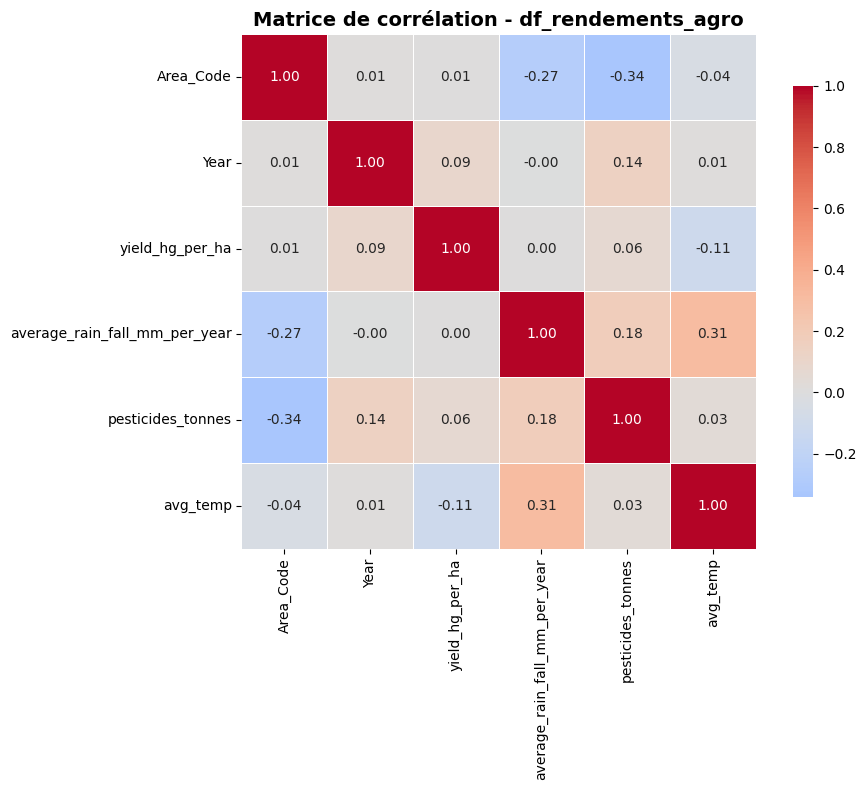

In [39]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = df_rendements_agro[colonnes_numeriques].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Matrice de corrélation - df_rendements_agro', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Observations :**
- Corrélation faible entre variables climatiques et rendement (données agrégées)
- Rainfall et avg_temp : corrélation positive (0.18-0.31)

## 3.5 Informations clés

In [40]:
print("=" * 50)
print("INFORMATIONS CLÉS - df_rendements_agro")
print("=" * 50)
print(f"Nombre de pays : {df_rendements_agro['Area'].nunique()}")
print(f"Nombre de cultures : {df_rendements_agro['Item'].nunique()}")
print(f"Cultures : {df_rendements_agro['Item'].unique().tolist()}")
print(f"Période : {df_rendements_agro['Year'].min()} - {df_rendements_agro['Year'].max()}")
print(f"Shape finale : {df_rendements_agro.shape}")

INFORMATIONS CLÉS - df_rendements_agro
Nombre de pays : 101
Nombre de cultures : 10
Cultures : ['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat', 'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams']
Période : 1990 - 2013
Shape finale : (28242, 8)


## 3.6 Sauvegarde

In [41]:
output_path = OUTPUT_DIR / "rendements_agro_clean.csv"
df_rendements_agro.to_csv(output_path, index=False)
print(f"✅ Dataset nettoyé sauvegardé : {output_path}")
print(f"Shape final : {df_rendements_agro.shape}")

✅ Dataset nettoyé sauvegardé : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean\rendements_agro_clean.csv
Shape final : (28242, 8)


## ✅ Conclusion df_rendements_agro

**Nettoyages effectués :**
- ✅ Suppression de la colonne Unnamed: 0
- ✅ Outliers analysés PAR CULTURE (pas de suppression, valeurs normales)

**Dataset final :**
- 28,242 lignes, 7 colonnes
- 101 pays, 10 cultures
- Période : 1990-2013
- **Variables clés :** Area, Item, Year, yield_hg_per_ha, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
- Clés de jointure : **Area, Item, Year**

---
# 4. DATASET 3 : df_pesticides

**Source :** `pesticides.csv` - Usage de pesticides par pays/année

## 4.1 Chargement et Vue d'ensemble

In [42]:
df_pesticides = pd.read_csv(DONNEES_AGRO_CLIMATIQUES / "pesticides.csv")
print(f"Shape : {df_pesticides.shape}")
df_pesticides.head()

Shape : (4349, 7)


,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [43]:
df_pesticides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   4349 non-null   object 
 1   Area     4349 non-null   object 
 2   Element  4349 non-null   object 
 3   Item     4349 non-null   object 
 4   Year     4349 non-null   int64  
 5   Unit     4349 non-null   object 
 6   Value    4349 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 238.0+ KB


Valeurs manquantes :
Domain     0
Area       0
Element    0
Item       0
Year       0
Unit       0
Value      0
dtype: int64


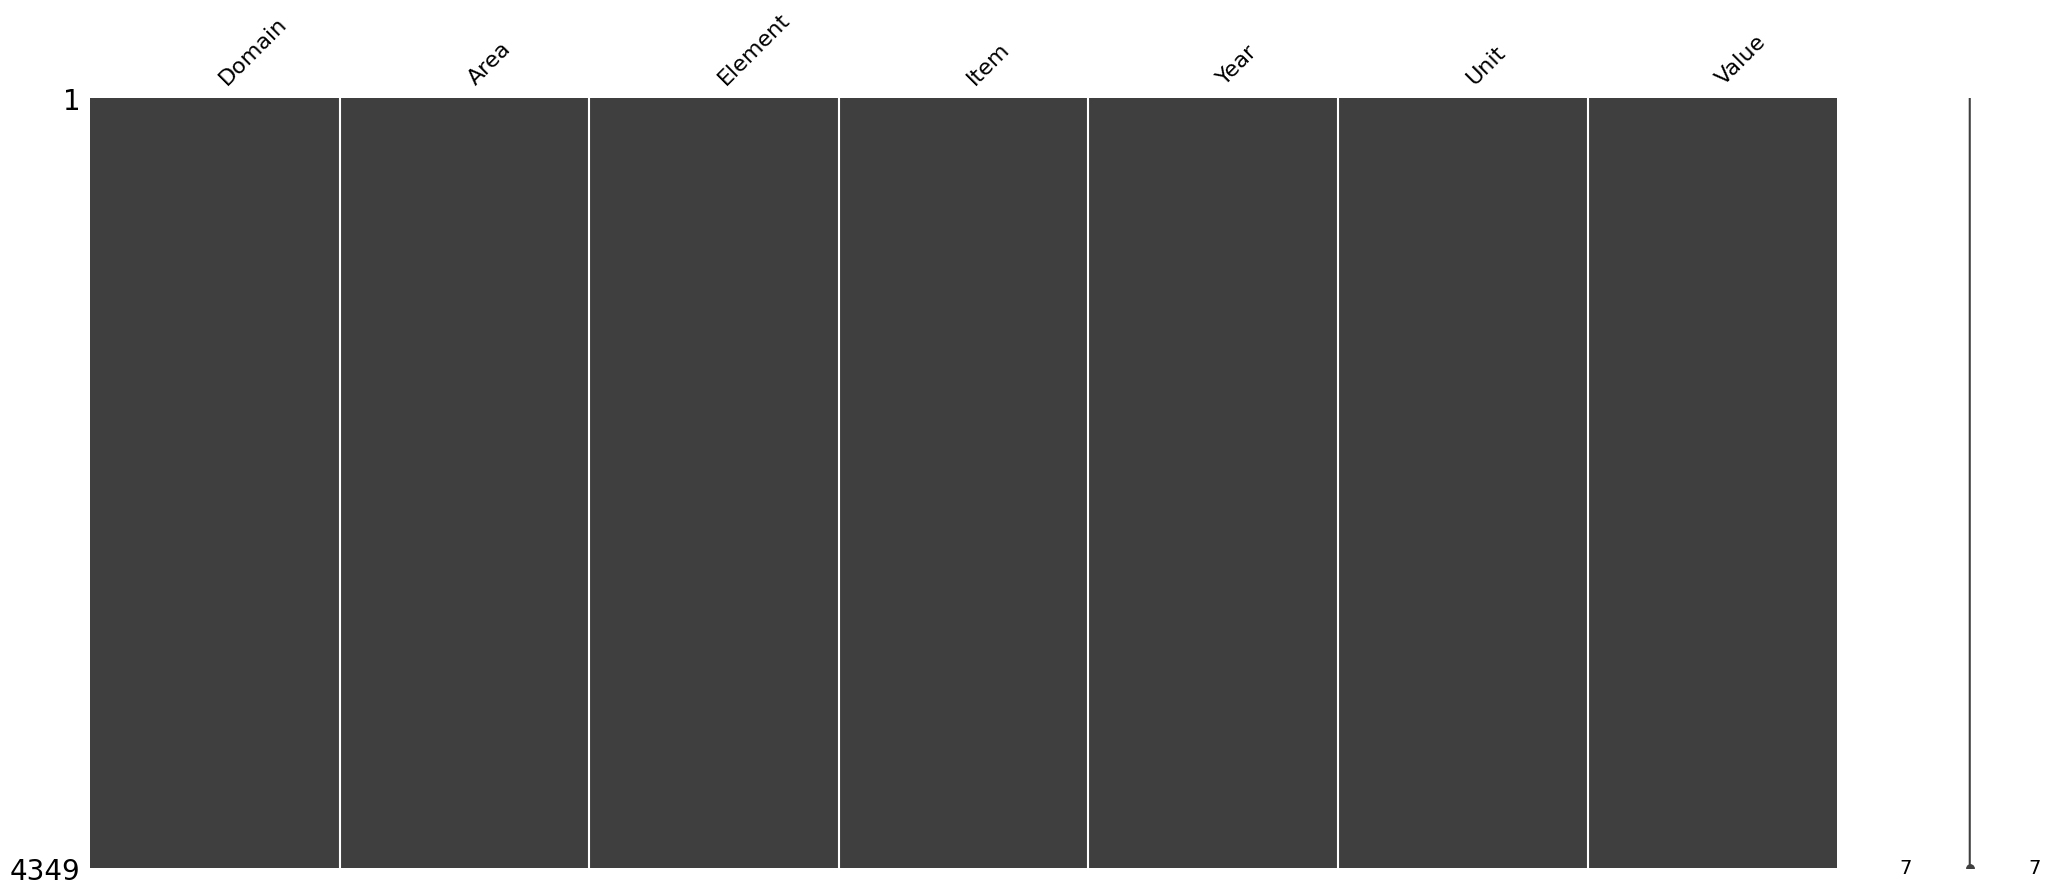

In [44]:
# Valeurs manquantes
print("Valeurs manquantes :")
print(df_pesticides.isnull().sum())
msno.matrix(df_pesticides)
plt.show()

**✅ Aucune valeur manquante**

## 4.2 Nettoyage des colonnes

In [45]:
# Identifier colonnes à valeur unique
print("Colonnes à valeur unique :")
for col in df_pesticides.columns:
    n_unique = df_pesticides[col].nunique()
    if n_unique == 1:
        print(f"  - {col} : {df_pesticides[col].unique()[0]}")

Colonnes à valeur unique :
  - Domain : Pesticides Use
  - Element : Use
  - Item : Pesticides (total)
  - Unit : tonnes of active ingredients


In [46]:
# Suppression des colonnes inutiles
colonnes_a_supprimer = ['Domain', 'Element', 'Item', 'Unit']

print(f"Avant suppression : {df_pesticides.shape}")
df_pesticides.drop(columns=colonnes_a_supprimer, inplace=True)
print(f"Après suppression : {df_pesticides.shape}")

Avant suppression : (4349, 7)
Après suppression : (4349, 3)


In [47]:
# Renommer Value → pesticides_tonnes
df_pesticides.rename(columns={'Value': 'pesticides_tonnes'}, inplace=True)
print("Colonnes après renommage :")
print(df_pesticides.columns.tolist())

Colonnes après renommage :
['Area', 'Year', 'pesticides_tonnes']


## 4.3 Informations clés

In [48]:
print("=" * 50)
print("INFORMATIONS CLÉS - df_pesticides")
print("=" * 50)
print(f"Nombre de pays : {df_pesticides['Area'].nunique()}")
print(f"Période : {df_pesticides['Year'].min()} - {df_pesticides['Year'].max()}")
print(f"Statistiques pesticides_tonnes :")
print(df_pesticides['pesticides_tonnes'].describe())
print(f"Shape finale : {df_pesticides.shape}")

INFORMATIONS CLÉS - df_pesticides
Nombre de pays : 168
Période : 1990 - 2016
Statistiques pesticides_tonnes :
count    4.349000e+03
mean     2.030334e+04
std      1.177362e+05
min      0.000000e+00
25%      9.300000e+01
50%      1.137560e+03
75%      7.869000e+03
max      1.807000e+06
Name: pesticides_tonnes, dtype: float64
Shape finale : (4349, 3)


Text(0.5, 1.0, 'Usage pesticides - TOP 15 pays')

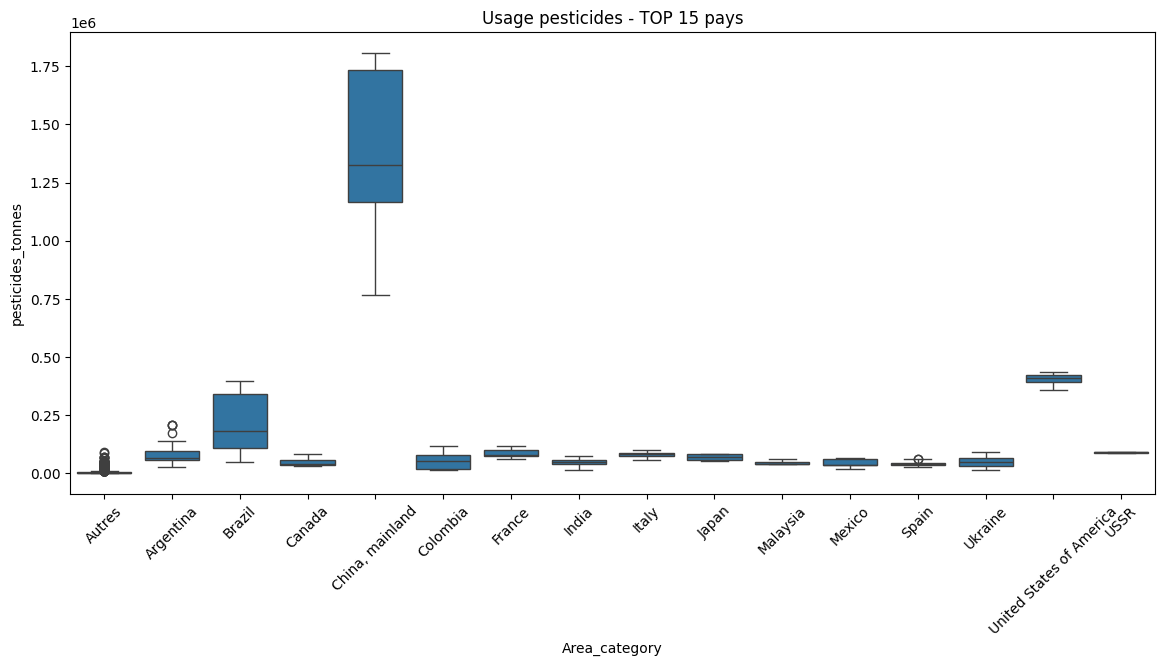

In [49]:
# 1. Identifier TOP 15 pays
top15 = df_pesticides.groupby('Area')['pesticides_tonnes'].mean().nlargest(15)

# 2. Créer catégorie "Autres"
df_pesticides['Area_category'] = df_pesticides['Area'].apply(
    lambda x: x if x in top15.index else 'Autres'
)

# 3. Boxplot par catégorie
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_pesticides, x='Area_category', y='pesticides_tonnes')
plt.xticks(rotation=45)
plt.title('Usage pesticides - TOP 15 pays')

Text(0, 0.5, 'log10(pesticides_tonnes)')

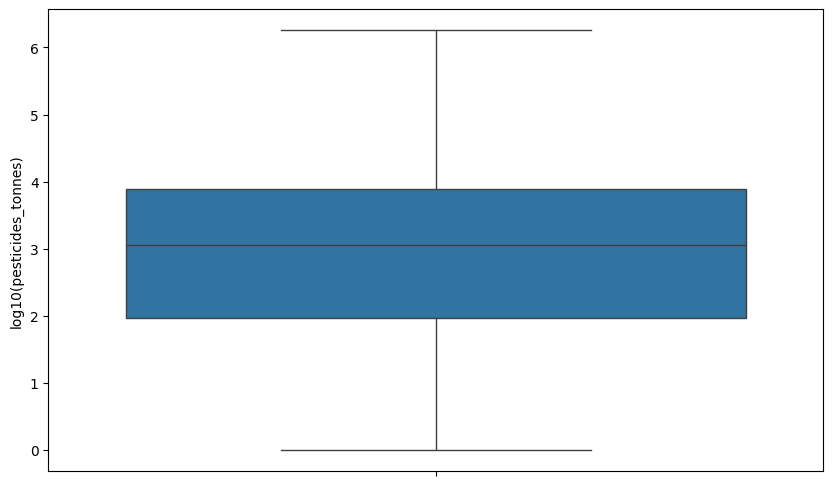

In [50]:
# Échelle logarithmique pour compresser la distribution
plt.figure(figsize=(10, 6))
sns.boxplot(y=np.log10(df_pesticides['pesticides_tonnes'] + 1))
plt.ylabel('log10(pesticides_tonnes)')

In [51]:
# Statistiques descriptives par pays
stats_pesticides = df_pesticides.groupby('Area')['pesticides_tonnes'].agg([
    'count', 'mean', 'median', 'std', 'max'
]).sort_values('mean', ascending=False)

print("TOP 10 pays (usage moyen) :")
print(stats_pesticides.head(10))

# → Identifier si Chine, USA, Brésil, Inde en tête = NORMAL

TOP 10 pays (usage moyen) :
                          count          mean      median            std  \
Area                                                                       
China, mainland              27  1.377587e+06  1325226.00  350780.830562   
United States of America     27  4.066033e+05   407779.20   19601.925928   
Brazil                       27  2.100575e+05   182446.00  118515.400410   
USSR                          2  8.920000e+04    89200.00    4242.640687   
Argentina                    27  8.333572e+04    64568.95   55643.170138   
France                       27  8.327432e+04    78577.00   15874.236019   
Italy                        27  7.826321e+04    80454.00   11083.404115   
Japan                        27  6.826507e+04    67869.72   11413.294411   
Colombia                     27  5.486039e+04    52883.00   30837.881027   
India                        27  4.898567e+04    49157.00   14436.438764   

                                 max  
Area                

## Analyse visuelle des outliers - Chine vs Reste du monde

In [52]:
# Séparer les données
china_data = df_pesticides[df_pesticides['Area'] == 'China, mainland']['pesticides_tonnes']
other_data = df_pesticides[df_pesticides['Area'] != 'China, mainland']['pesticides_tonnes']
abs# Statistiques comparatives
print(f"\n📈 Statistiques comparatives :")
print(f"Chine - Médiane : {china_data.median():,.0f} tonnes")
print(f"Chine - Max : {china_data.max():,.0f} tonnes")
print(f"Reste - Médiane : {other_data.median():,.0f} tonnes")
print(f"Reste - Max : {other_data.max():,.0f} tonnes")



📈 Statistiques comparatives :
Chine - Médiane : 1,325,226 tonnes
Chine - Max : 1,807,000 tonnes
Reste - Médiane : 1,094 tonnes
Reste - Max : 434,541 tonnes


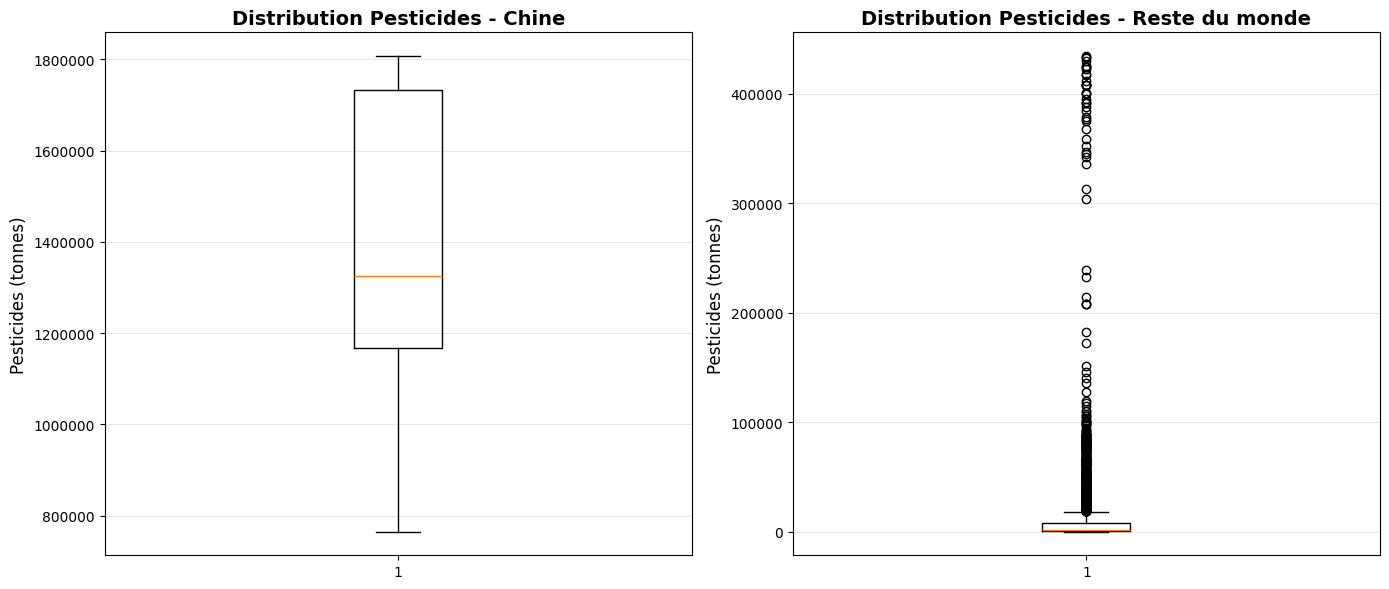

In [53]:
# Boxplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot Chine
axes[0].boxplot(china_data.dropna(), vert=True)
axes[0].set_title('Distribution Pesticides - Chine', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Pesticides (tonnes)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='y')

# Boxplot Reste du monde
axes[1].boxplot(other_data.dropna(), vert=True)
axes[1].set_title('Distribution Pesticides - Reste du monde', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pesticides (tonnes)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [54]:
print("\n✅ DÉCISION : Outliers Chine conservés")
print("Justification : Outlier structurel (1er producteur agricole mondial)")


✅ DÉCISION : Outliers Chine conservés
Justification : Outlier structurel (1er producteur agricole mondial)


## Ajout de Area_Code via table de correspondance

In [55]:
# Standardisation des noms de pays AVANT jointure

In [56]:
# Afficher les pays uniques avant standardisation
print(f"Pays uniques avant : {df_pesticides['Area'].nunique()}")

# Appliquer la standardisation
df_pesticides['Area'] = df_pesticides['Area'].replace(manual_mapping)

# Afficher après
print(f"Pays uniques après : {df_pesticides['Area'].nunique()}")

Pays uniques avant : 168
Pays uniques après : 168


In [57]:
# Charger la table de correspondance
area_mapping = pd.read_csv(OUTPUT_DIR / 'area_code_mapping.csv')

# Fusionner
shape_before = df_pesticides.shape
df_pesticides = df_pesticides.merge(area_mapping, on='Area', how='left')

print(f"Shape avant : {shape_before}")
print(f"Shape après : {df_pesticides.shape}")


Shape avant : (4349, 4)
Shape après : (4349, 5)


In [58]:
df_pesticides.head()

,Area,Year,pesticides_tonnes,Area_category,Area_Code
0,Albania,1990,121.0,Autres,3.0
1,Albania,1991,121.0,Autres,3.0
2,Albania,1992,121.0,Autres,3.0
3,Albania,1993,121.0,Autres,3.0
4,Albania,1994,201.0,Autres,3.0


In [59]:
# Vérifier correspondances manquantes APRÈS standardisation
missing = df_pesticides[df_pesticides['Area_Code'].isna()]

if len(missing) > 0:
    print(f"\n⚠️ {len(missing)} lignes sans Area_Code ({len(missing)/len(df_pesticides)*100:.1f}%)")
    print(f"Pays sans correspondance : {missing['Area'].nunique()} pays uniques")
    print("\nPays non résolus (TOP 10) :")
    print(missing['Area'].value_counts().head(10))
    
    # DÉCISION FINALE : Supprimer les lignes sans Area_Code
    print(f"\n🔴 SUPPRESSION des {len(missing)} lignes sans Area_Code")
    print("Justification : Pays non-FAO ou territoires autonomes sans équivalent agricole")
    
    df_pesticides = df_pesticides.dropna(subset=['Area_Code'])
    print(f"✅ Shape après suppression : {df_pesticides.shape}")
else:
    print("\n✅ Tous les pays ont un Area_Code correspondant")


⚠️ 27 lignes sans Area_Code (0.6%)
Pays sans correspondance : 1 pays uniques

Pays non résolus (TOP 10) :
Area
China, Macao Special Administrative Region    27
Name: count, dtype: int64

🔴 SUPPRESSION des 27 lignes sans Area_Code
Justification : Pays non-FAO ou territoires autonomes sans équivalent agricole
✅ Shape après suppression : (4322, 5)


In [60]:
# Vérifier correspondances manquantes
missing = df_pesticides[df_pesticides['Area_Code'].isna()]
if len(missing) > 0:
    print(f"\n⚠️ {len(missing)} lignes sans Area_Code ({len(missing)/len(df_pesticides)*100:.1f}%)")
    print(f"Pays sans correspondance : {missing['Area'].nunique()} pays uniques")
    print(missing['Area'].value_counts().head(10))
else:
    print("\n✅ Tous les pays ont un Area_Code")


✅ Tous les pays ont un Area_Code


In [61]:
# Réorganiser colonnes (Area_Code après Area)
cols = df_pesticides.columns.tolist()
if 'Area_Code' in cols:
    cols.remove('Area_Code')
    idx_area = cols.index('Area')
    cols.insert(idx_area + 1, 'Area_Code')
    df_pesticides = df_pesticides[cols]

print(f"\nColonnes finales : {df_pesticides.columns.tolist()}")


Colonnes finales : ['Area', 'Area_Code', 'Year', 'pesticides_tonnes', 'Area_category']


## 4.4 Sauvegarde

In [62]:
output_path = OUTPUT_DIR / "pesticides_clean.csv"
df_pesticides.to_csv(output_path, index=False)
print(f"✅ Dataset nettoyé sauvegardé : {output_path}")
print(f"Shape final : {df_pesticides.shape}")

✅ Dataset nettoyé sauvegardé : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean\pesticides_clean.csv
Shape final : (4322, 5)


## ✅ Conclusion df_pesticides

**Nettoyages effectués :**
- ✅ Suppression de 4 colonnes inutiles (Domain, Element, Item, Unit)
- ✅ Renommage Value → pesticides_tonnes

**Dataset final :**
- 4,349 lignes, 3 colonnes
- 168 pays
- Période : 1990-2018
- Clés de jointure : **Area, Year**

---
# 5. DATASET 4 : df_rainfall

**Source :** `rainfall.csv` - Précipitations moyennes annuelles

## 5.1 Chargement et Vue d'ensemble

In [63]:
df_rainfall = pd.read_csv(DONNEES_AGRO_CLIMATIQUES / "rainfall.csv")
print(f"Shape : {df_rainfall.shape}")
df_rainfall.head()

Shape : (6727, 3)


,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [64]:
df_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0    Area                          6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.8+ KB


Valeurs manquantes :
 Area                              0
Year                               0
average_rain_fall_mm_per_year    774
dtype: int64


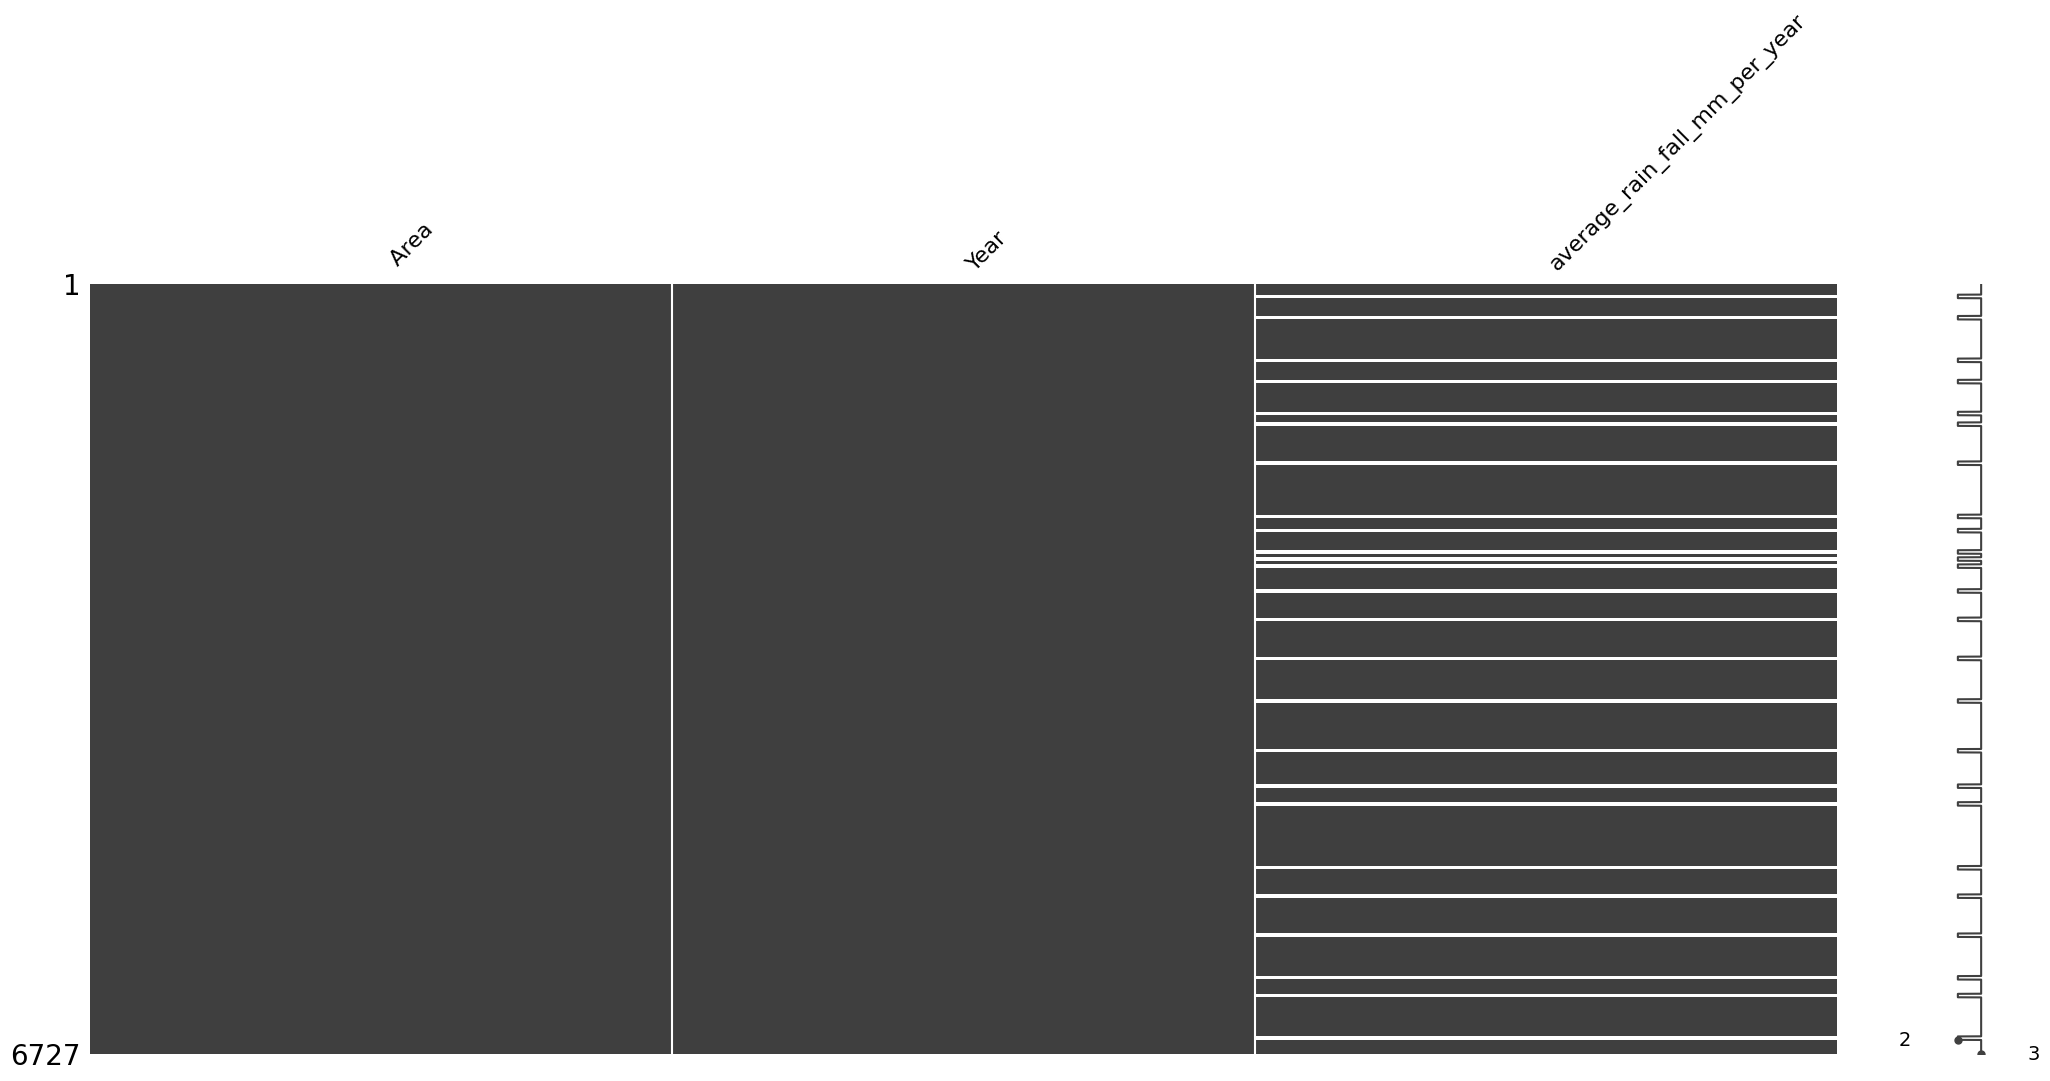

In [65]:
# Valeurs manquantes
print("Valeurs manquantes :")
print(df_rainfall.isnull().sum())
msno.matrix(df_rainfall)
plt.show()

**⚠️ 774 valeurs manquantes dans average_rain_fall_mm_per_year**

## 5.2 Nettoyage des colonnes

In [66]:
# Corriger le nom de la colonne Area (espace en début)
print("Colonnes avant renommage :")
print(df_rainfall.columns.tolist())

df_rainfall.columns = df_rainfall.columns.str.strip()

print("\nColonnes après renommage :")
print(df_rainfall.columns.tolist())

Colonnes avant renommage :
[' Area', 'Year', 'average_rain_fall_mm_per_year']

Colonnes après renommage :
['Area', 'Year', 'average_rain_fall_mm_per_year']


## 5.3 Nettoyage des valeurs

In [67]:
# Identifier les valeurs '..' (erreur de saisie)
valeurs_bizarres = df_rainfall[df_rainfall['average_rain_fall_mm_per_year'] == '..']
print(f"Nombre de lignes avec '..' : {len(valeurs_bizarres)}")
print("\nExemples :")
print(valeurs_bizarres)

Nombre de lignes avec '..' : 6

Exemples :
         Area  Year average_rain_fall_mm_per_year
403   Bahamas  1985                            ..
404   Bahamas  1986                            ..
406   Bahamas  1989                            ..
407   Bahamas  1990                            ..
408   Bahamas  1991                            ..
4061   Monaco  1985                            ..


In [68]:
# Suppression des lignes avec '..'
print(f"Shape avant suppression : {df_rainfall.shape}")
df_rainfall = df_rainfall[df_rainfall['average_rain_fall_mm_per_year'] != '..'].copy()
print(f"Shape après suppression : {df_rainfall.shape}")

Shape avant suppression : (6727, 3)
Shape après suppression : (6721, 3)


In [69]:
# Conversion en float
print(f"Type avant conversion : {df_rainfall['average_rain_fall_mm_per_year'].dtype}")
df_rainfall['average_rain_fall_mm_per_year'] = df_rainfall['average_rain_fall_mm_per_year'].astype(float)
print(f"Type après conversion : {df_rainfall['average_rain_fall_mm_per_year'].dtype}")

Type avant conversion : object
Type après conversion : float64


## Ajout de Area_Code via table de correspondance

In [70]:
# Standardisation des noms de pays AVANT jointure

In [71]:
# Afficher les pays uniques avant standardisation
print(f"Pays uniques avant : {df_rainfall['Area'].nunique()}")

# Appliquer la standardisation
df_rainfall['Area'] = df_rainfall['Area'].replace(manual_mapping)

# Afficher après
print(f"Pays uniques après : {df_rainfall['Area'].nunique()}")

Pays uniques avant : 217
Pays uniques après : 217


In [72]:
# Charger la table de correspondance
area_mapping = pd.read_csv(OUTPUT_DIR / 'area_code_mapping.csv')

# Fusionner
shape_before = df_rainfall.shape
df_rainfall = df_rainfall.merge(area_mapping, on='Area', how='left')

print(f"Shape avant : {shape_before}")
print(f"Shape après : {df_rainfall.shape}")


Shape avant : (6721, 3)
Shape après : (6721, 4)


In [73]:
# Vérifier correspondances manquantes APRÈS standardisation
missing = df_rainfall[df_rainfall['Area_Code'].isna()]

if len(missing) > 0:
    print(f"\n⚠️ {len(missing)} lignes sans Area_Code ({len(missing)/len(df_rainfall)*100:.1f}%)")
    print(f"Pays sans correspondance : {missing['Area'].nunique()} pays uniques")
    print("\nPays non résolus (TOP 10) :")
    print(missing['Area'].value_counts().head(10))
    
    # DÉCISION FINALE : Supprimer les lignes sans Area_Code
    print(f"\n🔴 SUPPRESSION des {len(missing)} lignes sans Area_Code")
    print("Justification : Pays non-FAO ou territoires autonomes sans équivalent agricole")
    
    df_rainfall = df_rainfall.dropna(subset=['Area_Code'])
    print(f"✅ Shape après suppression : {df_rainfall.shape}")
else:
    print("\n✅ Tous les pays ont un Area_Code correspondant")


⚠️ 1115 lignes sans Area_Code (16.6%)
Pays sans correspondance : 36 pays uniques

Pays non résolus (TOP 10) :
Area
Andorra                   31
Aruba                     31
British Virgin Islands    31
Channel Islands           31
Curacao                   31
Gibraltar                 31
Greenland                 31
Hong Kong SAR, China      31
Isle of Man               31
Kiribati                  31
Name: count, dtype: int64

🔴 SUPPRESSION des 1115 lignes sans Area_Code
Justification : Pays non-FAO ou territoires autonomes sans équivalent agricole
✅ Shape après suppression : (5606, 4)


In [74]:
# Vérifier correspondances manquantes
missing = df_rainfall[df_rainfall['Area_Code'].isna()]
if len(missing) > 0:
    print(f"\n⚠️ {len(missing)} lignes sans Area_Code ({len(missing)/len(df_rainfall)*100:.1f}%)")
    print(f"Pays sans correspondance : {missing['Area'].nunique()} pays uniques")
    print(missing['Area'].value_counts().head(10))
else:
    print("\n✅ Tous les pays ont un Area_Code")


✅ Tous les pays ont un Area_Code


In [75]:
# Réorganiser colonnes (Area_Code après Area)
cols = df_rainfall.columns.tolist()
if 'Area_Code' in cols:
    cols.remove('Area_Code')
    idx_area = cols.index('Area')
    cols.insert(idx_area + 1, 'Area_Code')
    df_rainfall = df_rainfall[cols]

print(f"\nColonnes finales : {df_rainfall.columns.tolist()}")


Colonnes finales : ['Area', 'Area_Code', 'Year', 'average_rain_fall_mm_per_year']


## 5.4 Informations clés

In [76]:
print("=" * 50)
print("INFORMATIONS CLÉS - df_rainfall")
print("=" * 50)
print(f"Nombre de pays : {df_rainfall['Area'].nunique()}")
print(f"Période : {df_rainfall['Year'].min()} - {df_rainfall['Year'].max()}")
print(f"Valeurs manquantes : {df_rainfall['average_rain_fall_mm_per_year'].isna().sum()}")
print(f"\nStatistiques average_rain_fall_mm_per_year :")
print(df_rainfall['average_rain_fall_mm_per_year'].describe())
print(f"Shape finale : {df_rainfall.shape}")

INFORMATIONS CLÉS - df_rainfall
Nombre de pays : 181
Période : 1985 - 2017
Valeurs manquantes : 248

Statistiques average_rain_fall_mm_per_year :
count    5358.000000
mean     1145.115528
std       799.068427
min        51.000000
25%       537.000000
50%      1026.000000
75%      1668.000000
max      3240.000000
Name: average_rain_fall_mm_per_year, dtype: float64
Shape finale : (5606, 4)


Top 5 pays pluvieux :           Area  Area_Code  Year  average_rain_fall_mm_per_year
1297  Colombia       44.0  1985                         3240.0
1298  Colombia       44.0  1986                         3240.0
1299  Colombia       44.0  1987                         3240.0
1300  Colombia       44.0  1989                         3240.0
1301  Colombia       44.0  1990                         3240.0
Top 5 pays secs :        Area  Area_Code  Year  average_rain_fall_mm_per_year
1793  Egypt       59.0  1985                           51.0
1794  Egypt       59.0  1986                           51.0
1795  Egypt       59.0  1987                           51.0
1796  Egypt       59.0  1989                           51.0
1797  Egypt       59.0  1990                           51.0


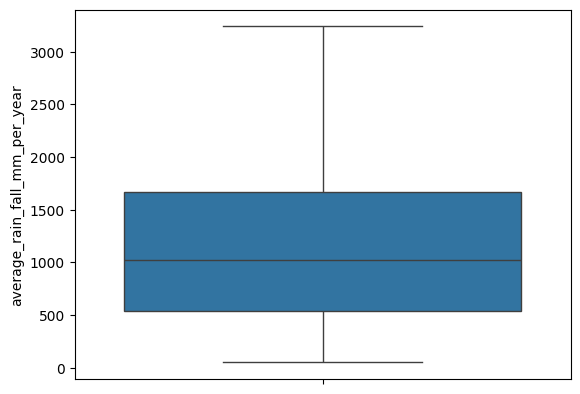

In [77]:
# Boxplot
sns.boxplot(y=df_rainfall['average_rain_fall_mm_per_year'])

# Identifier extrêmes
print("Top 5 pays pluvieux :", df_rainfall.nlargest(5, 'average_rain_fall_mm_per_year'))
print("Top 5 pays secs :", df_rainfall.nsmallest(5, 'average_rain_fall_mm_per_year'))

 **Outliers rainfall : CONSERVÉS**
  - Colombie 3240mm = Climat amazonien
  - Égypte 51mm = Climat désertique
  - Variabilité naturelle, pas d'erreurs détectées

## 5.5 Sauvegarde

In [78]:
output_path = OUTPUT_DIR / "rainfall_clean.csv"
df_rainfall.to_csv(output_path, index=False)
print(f"✅ Dataset nettoyé sauvegardé : {output_path}")
print(f"Shape final : {df_rainfall.shape}")

✅ Dataset nettoyé sauvegardé : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean\rainfall_clean.csv
Shape final : (5606, 4)


## ✅ Conclusion df_rainfall

**Nettoyages effectués :**
- ✅ Correction nom colonne ' Area' → 'Area'
- ✅ Suppression de 6 lignes avec '..' (Bahamas, Monaco)
- ✅ Conversion average_rain_fall_mm_per_year en float

**Dataset final :**
- 6,721 lignes, 3 colonnes
- 101 pays
- Période : 1985-2013
- ⚠️ **774 valeurs manquantes** (à gérer lors de la fusion)
- Clés de jointure : **Area, Year**

---
# 6. DATASET 5 : df_temp

**Source :** `temp.csv` - Températures moyennes annuelles

## 6.1 Chargement et Vue d'ensemble

In [79]:
df_temp = pd.read_csv(DONNEES_AGRO_CLIMATIQUES / "temp.csv")
print(f"Shape : {df_temp.shape}")
df_temp.head()

Shape : (71311, 3)


,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [80]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


Valeurs manquantes :
year           0
country        0
avg_temp    2547
dtype: int64


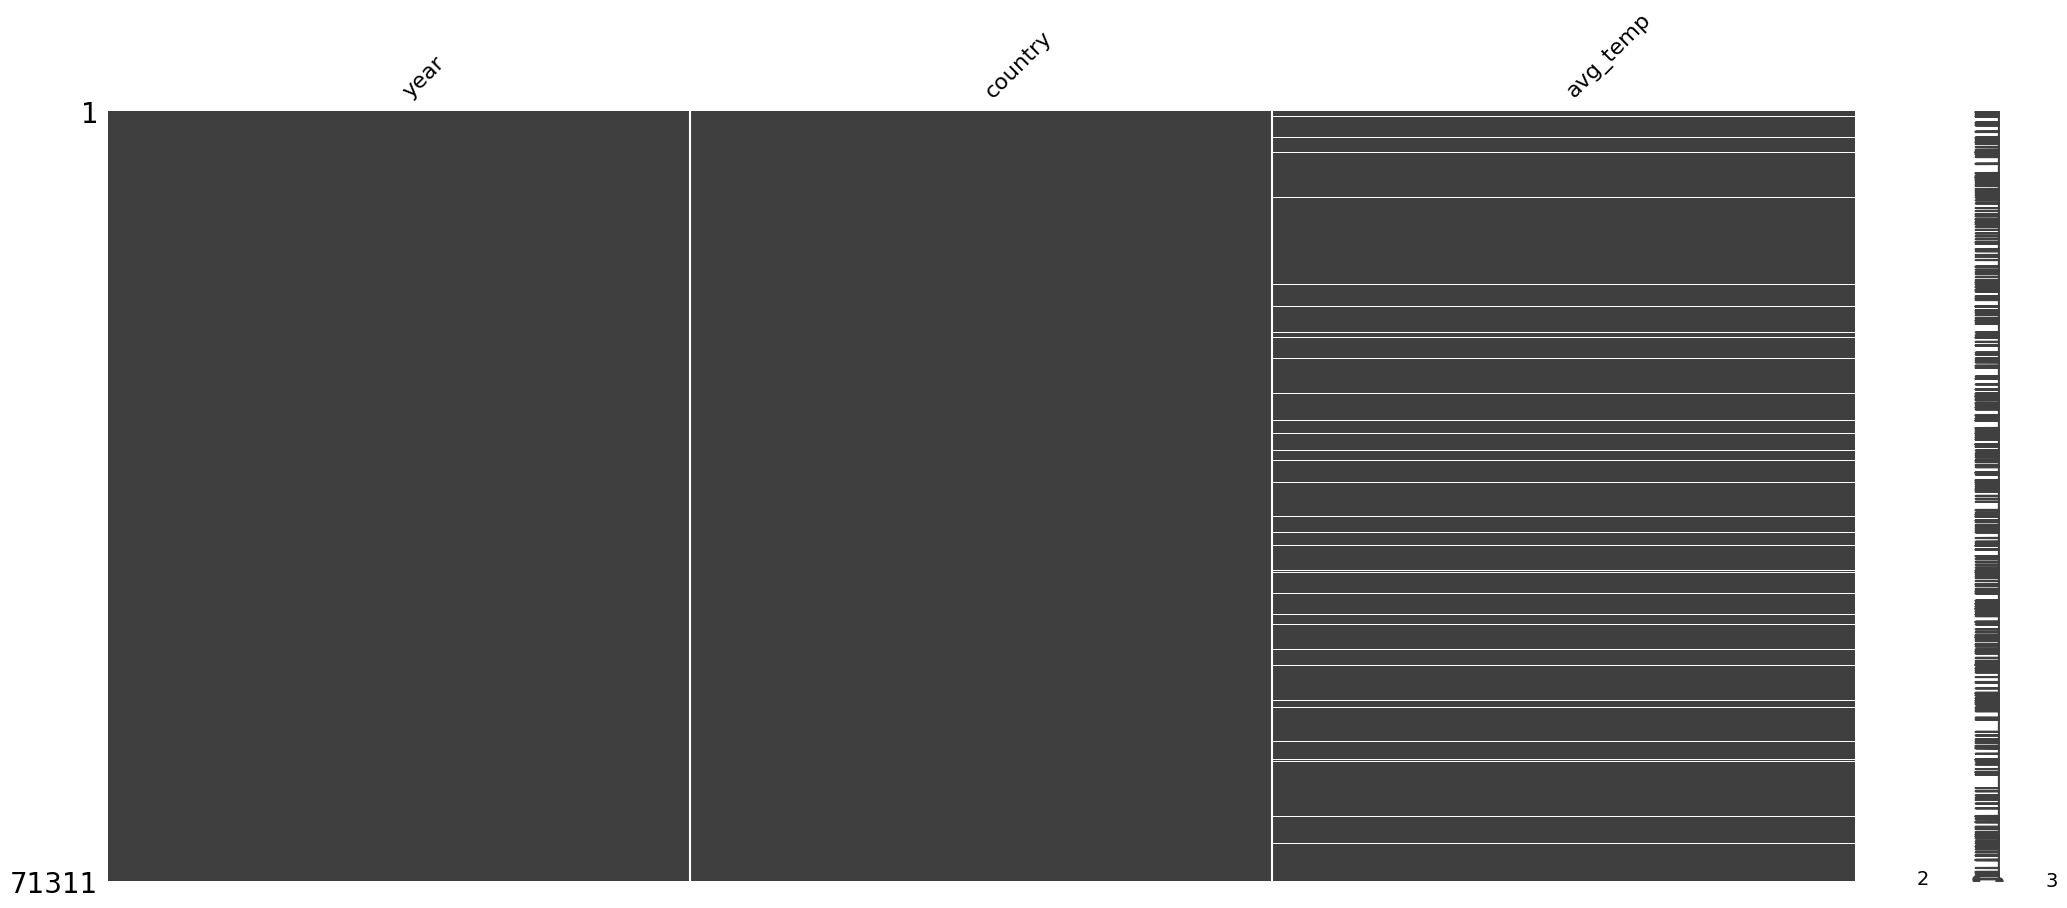

In [81]:
# Valeurs manquantes
print("Valeurs manquantes :")
print(df_temp.isnull().sum())
msno.matrix(df_temp)
plt.show()

**⚠️ 21,919 valeurs manquantes dans avg_temp (30.7%)**

## 6.2 Standardisation des noms de colonnes

In [82]:
# Renommer pour cohérence avec autres datasets
df_temp.rename(columns={'year': 'Year', 'country': 'Area'}, inplace=True)
print("Colonnes après renommage :")
print(df_temp.columns.tolist())

Colonnes après renommage :
['Year', 'Area', 'avg_temp']


## Ajout de Area_Code via table de correspondance

In [83]:
# Standardisation des noms de pays AVANT jointure

In [84]:
# Afficher les pays uniques avant standardisation
print(f"Pays uniques avant : {df_temp['Area'].nunique()}")

# Appliquer la standardisation
df_temp['Area'] = df_temp['Area'].replace(manual_mapping)

# Afficher après
print(f"Pays uniques après : {df_temp['Area'].nunique()}")

Pays uniques avant : 137
Pays uniques après : 137


In [85]:
# Charger la table de correspondance
area_mapping = pd.read_csv(OUTPUT_DIR / 'area_code_mapping.csv')

# Fusionner
shape_before = df_temp.shape
df_temp = df_temp.merge(area_mapping, on='Area', how='left')

print(f"Shape avant : {shape_before}")
print(f"Shape après : {df_temp.shape}")

Shape avant : (71311, 3)
Shape après : (71311, 4)


In [86]:
# Vérifier correspondances manquantes
missing = df_temp[df_temp['Area_Code'].isna()]
if len(missing) > 0:
    print(f"\n⚠️ {len(missing)} lignes sans Area_Code ({len(missing)/len(df_temp)*100:.1f}%)")
    print(f"Pays sans correspondance : {missing['Area'].nunique()} pays uniques")
    print(missing['Area'].value_counts().head(10))
else:
    print("\n✅ Tous les pays ont un Area_Code")


⚠️ 445 lignes sans Area_Code (0.6%)
Pays sans correspondance : 2 pays uniques
Area
North Macedonia                                   271
China, Hong Kong Special Administrative Region    174
Name: count, dtype: int64


In [87]:
# Suppression des lignes sans Area_Code

In [88]:
df_temp = df_temp.dropna(subset=['Area_Code'])

In [89]:
# Réorganiser colonnes (Area_Code après Area)
cols = df_temp.columns.tolist()
if 'Area_Code' in cols:
    cols.remove('Area_Code')
    idx_area = cols.index('Area')
    cols.insert(idx_area + 1, 'Area_Code')
    df_temp = df_temp[cols]

print(f"\nColonnes finales : {df_temp.columns.tolist()}")


Colonnes finales : ['Year', 'Area', 'Area_Code', 'avg_temp']


## 6.3 Informations clés

In [90]:
print("=" * 50)
print("INFORMATIONS CLÉS - df_temp")
print("=" * 50)
print(f"Nombre de pays : {df_temp['Area'].nunique()}")
print(f"Période : {df_temp['Year'].min()} - {df_temp['Year'].max()}")
print(f"Valeurs manquantes : {df_temp['avg_temp'].isna().sum()} ({df_temp['avg_temp'].isna().sum()/len(df_temp)*100:.1f}%)")
print(f"\nStatistiques avg_temp :")
print(df_temp['avg_temp'].describe())
print(f"Shape finale : {df_temp.shape}")

INFORMATIONS CLÉS - df_temp
Nombre de pays : 135
Période : 1743 - 2013
Valeurs manquantes : 2543 (3.6%)

Statistiques avg_temp :
count    68323.000000
mean        16.196476
std          7.601223
min        -14.350000
25%          9.760000
50%         16.150000
75%         23.820000
max         30.730000
Name: avg_temp, dtype: float64
Shape finale : (70866, 4)


## 6.4 Sauvegarde

In [91]:
output_path = OUTPUT_DIR / "temp_clean.csv"
df_temp.to_csv(output_path, index=False)
print(f"✅ Dataset nettoyé sauvegardé : {output_path}")
print(f"Shape final : {df_temp.shape}")
print(f"Colonnes : {df_temp.columns.tolist()}")

✅ Dataset nettoyé sauvegardé : C:\Users\Fab\Documents\P12_systeme_reco_agriculture\data\raw\crop_yield_prediction_dataset\clean\temp_clean.csv
Shape final : (70866, 4)
Colonnes : ['Year', 'Area', 'Area_Code', 'avg_temp']


## ✅ Conclusion df_temp

**Nettoyages effectués :**
- ✅ Renommage year → Year, country → Area (standardisation)

**Dataset final :**
- 71,311 lignes, 3 colonnes
- 243 pays
- Période : 1849-2013 (très longue période)
- ⚠️ **21,919 valeurs manquantes** (30.7%, à gérer lors de la fusion)
- Clés de jointure : **Area, Year**

#  SYNTHÈSE FINALE & STRATÉGIE DE FUSION
## Récapitulatif des datasets nettoyés

In [92]:
print("=" * 80)
print("📊 SYNTHÈSE - DATASETS NETTOYÉS ET VALIDÉS")
print("=" * 80)

# Charger tous les datasets nettoyés pour vérification
df_rendements_fao = pd.read_csv(OUTPUT_DIR / "rendements_fao_clean.csv")
df_rendements_agro = pd.read_csv(OUTPUT_DIR / "rendements_agro_clean.csv")
df_pesticides = pd.read_csv(OUTPUT_DIR / "pesticides_clean.csv")
df_rainfall = pd.read_csv(OUTPUT_DIR / "rainfall_clean.csv")
df_temp = pd.read_csv(OUTPUT_DIR / "temp_clean.csv")

# Tableau récapitulatif
datasets_summary = {
    "Dataset": [
        "df_rendements_fao",
        "df_rendements_agro", 
        "df_pesticides",
        "df_rainfall",
        "df_temp"
    ],
    "Lignes": [
        len(df_rendements_fao),
        len(df_rendements_agro),
        len(df_pesticides),
        len(df_rainfall),
        len(df_temp)
    ],
    "Colonnes": [
        len(df_rendements_fao.columns),
        len(df_rendements_agro.columns),
        len(df_pesticides.columns),
        len(df_rainfall.columns),
        len(df_temp.columns)
    ],
    "Période": [
        f"{df_rendements_fao['Year'].min()}-{df_rendements_fao['Year'].max()}",
        f"{df_rendements_agro['Year'].min()}-{df_rendements_agro['Year'].max()}",
        f"{df_pesticides['Year'].min()}-{df_pesticides['Year'].max()}",
        f"{df_rainfall['Year'].min()}-{df_rainfall['Year'].max()}",
        f"{df_temp['Year'].min()}-{df_temp['Year'].max()}"
    ],
    "Pays": [
        df_rendements_fao['Area'].nunique(),
        df_rendements_agro['Area'].nunique(),
        df_pesticides['Area'].nunique(),
        df_rainfall['Area'].nunique(),
        df_temp['Area'].nunique()
    ],
    "Area_Code": [
        "✅ OUI" if 'Area_Code' in df_rendements_fao.columns else "❌ NON",
        "✅ OUI" if 'Area_Code' in df_rendements_agro.columns else "❌ NON",
        "✅ OUI" if 'Area_Code' in df_pesticides.columns else "❌ NON",
        "✅ OUI" if 'Area_Code' in df_rainfall.columns else "❌ NON",
        "✅ OUI" if 'Area_Code' in df_temp.columns else "❌ NON"
    ]
}

summary_df = pd.DataFrame(datasets_summary)
print("\n")
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)

📊 SYNTHÈSE - DATASETS NETTOYÉS ET VALIDÉS


           Dataset  Lignes  Colonnes   Période  Pays Area_Code
 df_rendements_fao   56708         6 1961-2016   212     ✅ OUI
df_rendements_agro   28242         8 1990-2013   101     ✅ OUI
     df_pesticides    4322         5 1990-2016   167     ✅ OUI
       df_rainfall    5606         4 1985-2017   181     ✅ OUI
           df_temp   70866         4 1743-2013   135     ✅ OUI



##  Validation des clés de jointure

In [93]:
print("\n" + "=" * 80)
print("🔑 VALIDATION DES CLÉS DE JOINTURE")
print("=" * 80)

# Vérifier Area_Code présent partout
print("\n✅ Vérification Area_Code :")
for name, df in [
    ("df_rendements_fao", df_rendements_fao),
    ("df_rendements_agro", df_rendements_agro),
    ("df_pesticides", df_pesticides),
    ("df_rainfall", df_rainfall),
    ("df_temp", df_temp)
]:
    has_area_code = 'Area_Code' in df.columns
    na_count = df['Area_Code'].isna().sum() if has_area_code else "N/A"
    status = "✅" if has_area_code and na_count == 0 else "❌"
    print(f"  {status} {name:25} → Area_Code présent : {has_area_code}, NaN : {na_count}")

# Vérifier Year présent partout
print("\n✅ Vérification Year :")
for name, df in [
    ("df_rendements_fao", df_rendements_fao),
    ("df_rendements_agro", df_rendements_agro),
    ("df_pesticides", df_pesticides),
    ("df_rainfall", df_rainfall),
    ("df_temp", df_temp)
]:
    has_year = 'Year' in df.columns
    na_count = df['Year'].isna().sum() if has_year else "N/A"
    status = "✅" if has_year and na_count == 0 else "❌"
    print(f"  {status} {name:25} → Year présent : {has_year}, NaN : {na_count}")

# Vérifier Item (cultures) - uniquement pour rendements
print("\n✅ Vérification Item (cultures) :")
for name, df in [
    ("df_rendements_fao", df_rendements_fao),
    ("df_rendements_agro", df_rendements_agro)
]:
    has_item = 'Item' in df.columns
    unique_items = df['Item'].nunique() if has_item else "N/A"
    print(f"  ✅ {name:25} → Item présent : {has_item}, cultures uniques : {unique_items}")

print("\n" + "=" * 80)


🔑 VALIDATION DES CLÉS DE JOINTURE

✅ Vérification Area_Code :
  ✅ df_rendements_fao         → Area_Code présent : True, NaN : 0
  ✅ df_rendements_agro        → Area_Code présent : True, NaN : 0
  ✅ df_pesticides             → Area_Code présent : True, NaN : 0
  ✅ df_rainfall               → Area_Code présent : True, NaN : 0
  ✅ df_temp                   → Area_Code présent : True, NaN : 0

✅ Vérification Year :
  ✅ df_rendements_fao         → Year présent : True, NaN : 0
  ✅ df_rendements_agro        → Year présent : True, NaN : 0
  ✅ df_pesticides             → Year présent : True, NaN : 0
  ✅ df_rainfall               → Year présent : True, NaN : 0
  ✅ df_temp                   → Year présent : True, NaN : 0

✅ Vérification Item (cultures) :
  ✅ df_rendements_fao         → Item présent : True, cultures uniques : 10
  ✅ df_rendements_agro        → Item présent : True, cultures uniques : 10



## Analyse de chevauchement temporel


📅 ANALYSE DE CHEVAUCHEMENT TEMPOREL

Période couverte par chaque dataset :
  • df_rendements_fao   : 1961 - 2016 (56 années)
  • df_rendements_agro  : 1990 - 2013 (23 années)
  • df_pesticides       : 1990 - 2016 (27 années)
  • df_rainfall         : 1985 - 2017 (31 années)
  • df_temp             : 1743 - 2013 (271 années)

🎯 PÉRIODE COMMUNE (tous datasets) : 1990 - 2013 (23 années)
   Années disponibles : [np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1993), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013)]


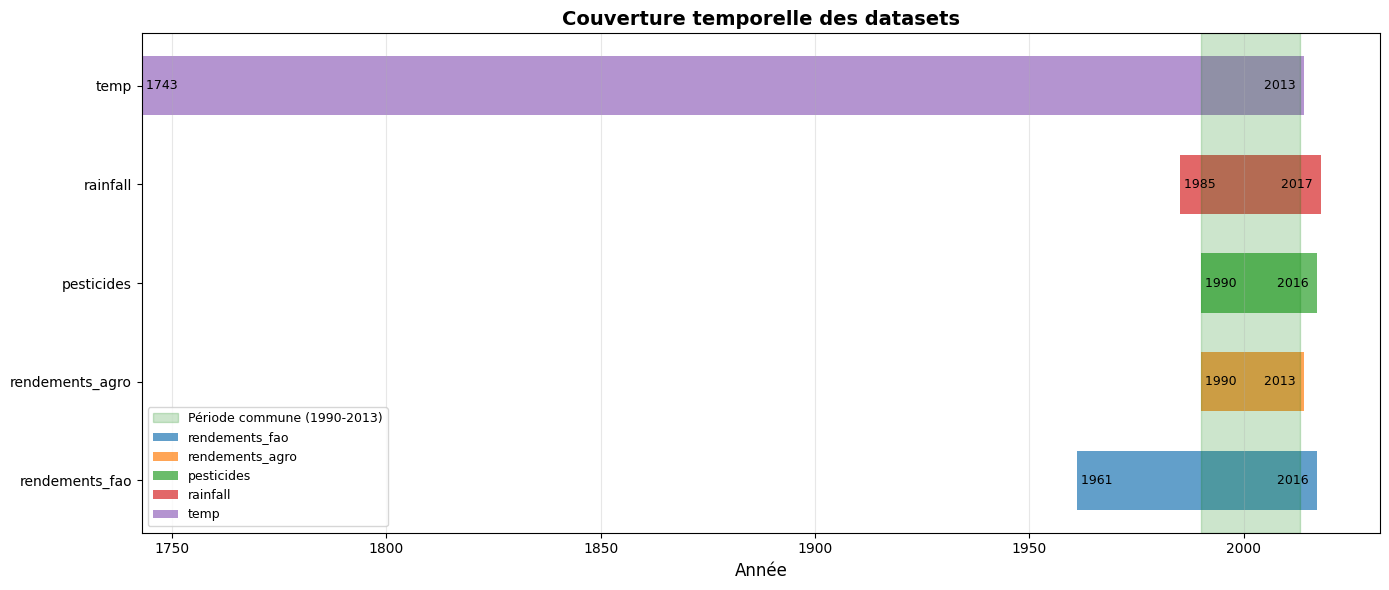

In [95]:
print("\n" + "=" * 80)
print("📅 ANALYSE DE CHEVAUCHEMENT TEMPOREL")
print("=" * 80)

# Identifier la période commune optimale
years_fao = set(df_rendements_fao['Year'].unique())
years_agro = set(df_rendements_agro['Year'].unique())
years_pesticides = set(df_pesticides['Year'].unique())
years_rainfall = set(df_rainfall['Year'].unique())
years_temp = set(df_temp['Year'].unique())

# Intersection complète (tous les datasets)
years_all = years_fao & years_agro & years_pesticides & years_rainfall & years_temp

print(f"\nPériode couverte par chaque dataset :")
print(f"  • df_rendements_fao   : {min(years_fao)} - {max(years_fao)} ({len(years_fao)} années)")
print(f"  • df_rendements_agro  : {min(years_agro)} - {max(years_agro)} ({len(years_agro)} années)")
print(f"  • df_pesticides       : {min(years_pesticides)} - {max(years_pesticides)} ({len(years_pesticides)} années)")
print(f"  • df_rainfall         : {min(years_rainfall)} - {max(years_rainfall)} ({len(years_rainfall)} années)")
print(f"  • df_temp             : {min(years_temp)} - {max(years_temp)} ({len(years_temp)} années)")

print(f"\n🎯 PÉRIODE COMMUNE (tous datasets) : {min(years_all)} - {max(years_all)} ({len(years_all)} années)")
print(f"   Années disponibles : {sorted(years_all)}")

# Visualisation du chevauchement
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

datasets_timeline = [
    ("rendements_fao", min(years_fao), max(years_fao)),
    ("rendements_agro", min(years_agro), max(years_agro)),
    ("pesticides", min(years_pesticides), max(years_pesticides)),
    ("rainfall", min(years_rainfall), max(years_rainfall)),
    ("temp", min(years_temp), max(years_temp))
]

for i, (name, start, end) in enumerate(datasets_timeline):
    ax.barh(i, end - start + 1, left=start, height=0.6, 
            label=name, alpha=0.7)
    ax.text(start, i, f" {start}", va='center', fontsize=9)
    ax.text(end, i, f"{end} ", va='center', ha='right', fontsize=9)

# Zone commune
if years_all:
    ax.axvspan(min(years_all), max(years_all), alpha=0.2, color='green', 
               label=f'Période commune ({min(years_all)}-{max(years_all)})')

ax.set_yticks(range(len(datasets_timeline)))
ax.set_yticklabels([name for name, _, _ in datasets_timeline])
ax.set_xlabel('Année', fontsize=12)
ax.set_title('Couverture temporelle des datasets', fontsize=14, fontweight='bold')

ax.legend(loc='lower left', fontsize=9)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Investigations sur les sources de données (anticipation de résolution des conflits)
Les donneés concernant les pesticides, la pluviométrie et les températures moyennes coexistent à la fois dans df_rendements_agro et les datsets dédiés. Avant de statuer sur la stratégie de fusion, il faut investiguer pour savoir quelles valeurs conserver.

In [96]:
# ============================================================
# INVESTIGATION : Comparaison des sources de données
# ============================================================

print("=" * 80)
print("🔬 INVESTIGATION - COMPARAISON DES SOURCES")
print("=" * 80)

# Charger les datasets
df_rendements_agro = pd.read_csv(OUTPUT_DIR / "rendements_agro_clean.csv")
df_rainfall = pd.read_csv(OUTPUT_DIR / "rainfall_clean.csv")
df_temp = pd.read_csv(OUTPUT_DIR / "temp_clean.csv")
df_pesticides = pd.read_csv(OUTPUT_DIR / "pesticides_clean.csv")

# ============================================================
# TEST 1 : Rainfall - Comparer les valeurs communes
# ============================================================

print("\n" + "─" * 80)
print("TEST 1 : Comparaison average_rain_fall_mm_per_year")
print("─" * 80)

# Merger pour comparer
comparison_rainfall = df_rendements_agro[['Area_Code', 'Year', 'average_rain_fall_mm_per_year']].merge(
    df_rainfall[['Area_Code', 'Year', 'average_rain_fall_mm_per_year']],
    on=['Area_Code', 'Year'],
    how='inner',
    suffixes=('_agro', '_rainfall')
)

print(f"\nNombre de lignes communes : {len(comparison_rainfall)}")

# Calculer la différence
comparison_rainfall['diff'] = abs(
    comparison_rainfall['average_rain_fall_mm_per_year_agro'] - 
    comparison_rainfall['average_rain_fall_mm_per_year_rainfall']
)

comparison_rainfall['diff_pct'] = (
    comparison_rainfall['diff'] / 
    comparison_rainfall['average_rain_fall_mm_per_year_agro'] * 100
)

# Statistiques
print(f"\n📊 Statistiques de différence :")
print(f"  • Différence moyenne : {comparison_rainfall['diff'].mean():.2f} mm")
print(f"  • Différence médiane : {comparison_rainfall['diff'].median():.2f} mm")
print(f"  • Différence max : {comparison_rainfall['diff'].max():.2f} mm")
print(f"  • Différence % moyenne : {comparison_rainfall['diff_pct'].mean():.2f}%")

# Identifier les valeurs identiques
identical = (comparison_rainfall['diff'] == 0).sum()
total = len(comparison_rainfall)
pct_identical = identical / total * 100

print(f"\n✅ Valeurs IDENTIQUES : {identical}/{total} ({pct_identical:.1f}%)")
print(f"❌ Valeurs DIFFÉRENTES : {total - identical}/{total} ({100 - pct_identical:.1f}%)")

# Afficher exemples de différences
if total - identical > 0:
    print("\n🔍 Exemples de différences (TOP 10) :")
    print(comparison_rainfall.nlargest(10, 'diff')[
        ['Area_Code', 'Year', 'average_rain_fall_mm_per_year_agro', 
         'average_rain_fall_mm_per_year_rainfall', 'diff', 'diff_pct']
    ])

# ============================================================
# TEST 2 : Temperature - Comparer les valeurs communes
# ============================================================

print("\n" + "─" * 80)
print("TEST 2 : Comparaison avg_temp")
print("─" * 80)

comparison_temp = df_rendements_agro[['Area_Code', 'Year', 'avg_temp']].merge(
    df_temp[['Area_Code', 'Year', 'avg_temp']],
    on=['Area_Code', 'Year'],
    how='inner',
    suffixes=('_agro', '_temp')
)

print(f"\nNombre de lignes communes : {len(comparison_temp)}")

comparison_temp['diff'] = abs(
    comparison_temp['avg_temp_agro'] - 
    comparison_temp['avg_temp_temp']
)

comparison_temp['diff_pct'] = (
    comparison_temp['diff'] / 
    comparison_temp['avg_temp_agro'].abs() * 100
)

print(f"\n📊 Statistiques de différence :")
print(f"  • Différence moyenne : {comparison_temp['diff'].mean():.2f}°C")
print(f"  • Différence médiane : {comparison_temp['diff'].median():.2f}°C")
print(f"  • Différence max : {comparison_temp['diff'].max():.2f}°C")
print(f"  • Différence % moyenne : {comparison_temp['diff_pct'].mean():.2f}%")

identical = (comparison_temp['diff'] < 0.01).sum()  # Tolérance 0.01°C
total = len(comparison_temp)
pct_identical = identical / total * 100

print(f"\n✅ Valeurs IDENTIQUES (±0.01°C) : {identical}/{total} ({pct_identical:.1f}%)")
print(f"❌ Valeurs DIFFÉRENTES : {total - identical}/{total} ({100 - pct_identical:.1f}%)")

if total - identical > 0:
    print("\n🔍 Exemples de différences (TOP 10) :")
    print(comparison_temp.nlargest(10, 'diff')[
        ['Area_Code', 'Year', 'avg_temp_agro', 'avg_temp_temp', 'diff', 'diff_pct']
    ])

# ============================================================
# TEST 3 : Pesticides - Comparer les valeurs communes
# ============================================================

print("\n" + "─" * 80)
print("TEST 3 : Comparaison pesticides_tonnes")
print("─" * 80)

comparison_pest = df_rendements_agro[['Area_Code', 'Year', 'pesticides_tonnes']].merge(
    df_pesticides[['Area_Code', 'Year', 'pesticides_tonnes']],
    on=['Area_Code', 'Year'],
    how='inner',
    suffixes=('_agro', '_pest')
)

print(f"\nNombre de lignes communes : {len(comparison_pest)}")

comparison_pest['diff'] = abs(
    comparison_pest['pesticides_tonnes_agro'] - 
    comparison_pest['pesticides_tonnes_pest']
)

comparison_pest['diff_pct'] = (
    comparison_pest['diff'] / 
    comparison_pest['pesticides_tonnes_agro'] * 100
)

print(f"\n📊 Statistiques de différence :")
print(f"  • Différence moyenne : {comparison_pest['diff'].mean():.2f} tonnes")
print(f"  • Différence médiane : {comparison_pest['diff'].median():.2f} tonnes")
print(f"  • Différence max : {comparison_pest['diff'].max():.2f} tonnes")
print(f"  • Différence % moyenne : {comparison_pest['diff_pct'].mean():.2f}%")

identical = (comparison_pest['diff'] < 0.01).sum()
total = len(comparison_pest)
pct_identical = identical / total * 100

print(f"\n✅ Valeurs IDENTIQUES : {identical}/{total} ({pct_identical:.1f}%)")
print(f"❌ Valeurs DIFFÉRENTES : {total - identical}/{total} ({100 - pct_identical:.1f}%)")

if total - identical > 0:
    print("\n🔍 Exemples de différences (TOP 10) :")
    print(comparison_pest.nlargest(10, 'diff')[
        ['Area_Code', 'Year', 'pesticides_tonnes_agro', 'pesticides_tonnes_pest', 'diff', 'diff_pct']
    ])

print("\n" + "=" * 80)

🔬 INVESTIGATION - COMPARAISON DES SOURCES

────────────────────────────────────────────────────────────────────────────────
TEST 1 : Comparaison average_rain_fall_mm_per_year
────────────────────────────────────────────────────────────────────────────────

Nombre de lignes communes : 28242

📊 Statistiques de différence :
  • Différence moyenne : 0.00 mm
  • Différence médiane : 0.00 mm
  • Différence max : 0.00 mm
  • Différence % moyenne : 0.00%

✅ Valeurs IDENTIQUES : 28242/28242 (100.0%)
❌ Valeurs DIFFÉRENTES : 0/28242 (0.0%)

────────────────────────────────────────────────────────────────────────────────
TEST 2 : Comparaison avg_temp
────────────────────────────────────────────────────────────────────────────────

Nombre de lignes communes : 186094

📊 Statistiques de différence :
  • Différence moyenne : 1.72°C
  • Différence médiane : 1.02°C
  • Différence max : 10.56°C
  • Différence % moyenne : 8.57%

✅ Valeurs IDENTIQUES (±0.01°C) : 33454/186094 (18.0%)
❌ Valeurs DIFFÉRENTES :

In [97]:
# Comparer la couverture
print("\n" + "=" * 80)
print("📊 COMPARAISON DE COUVERTURE")
print("=" * 80)

print(f"\nRainfall :")
print(f"  • df_rendements_agro : {df_rendements_agro['average_rain_fall_mm_per_year'].notna().sum()} valeurs non-NaN")
print(f"  • df_rainfall        : {len(df_rainfall)} valeurs")

print(f"\nTemperature :")
print(f"  • df_rendements_agro : {df_rendements_agro['avg_temp'].notna().sum()} valeurs non-NaN")
print(f"  • df_temp            : {len(df_temp)} valeurs")

print(f"\nPesticides :")
print(f"  • df_rendements_agro : {df_rendements_agro['pesticides_tonnes'].notna().sum()} valeurs non-NaN")
print(f"  • df_pesticides      : {len(df_pesticides)} valeurs")


📊 COMPARAISON DE COUVERTURE

Rainfall :
  • df_rendements_agro : 28242 valeurs non-NaN
  • df_rainfall        : 5606 valeurs

Temperature :
  • df_rendements_agro : 28242 valeurs non-NaN
  • df_temp            : 70866 valeurs

Pesticides :
  • df_rendements_agro : 28242 valeurs non-NaN
  • df_pesticides      : 4322 valeurs


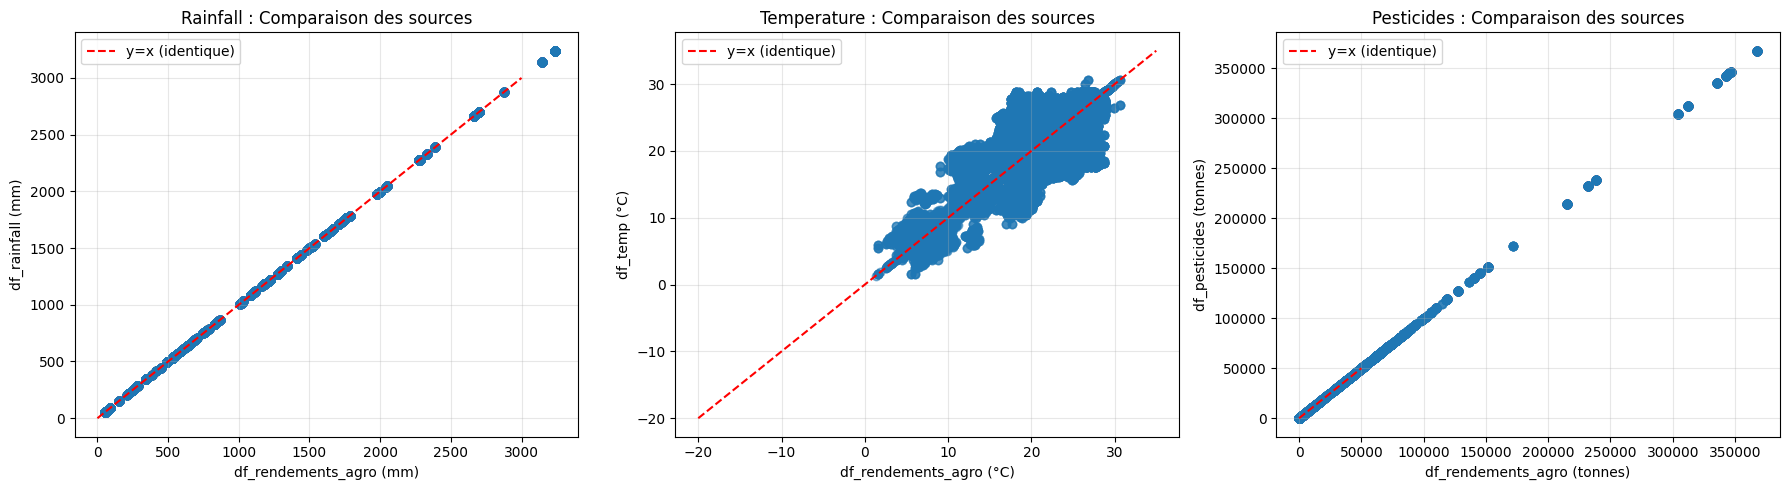


📊 CORRÉLATIONS :
  • Rainfall    : r = 1.0000
  • Temperature : r = 0.8585
  • Pesticides  : r = 1.0000


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exemple pour rainfall
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rainfall
axes[0].scatter(
    comparison_rainfall['average_rain_fall_mm_per_year_agro'],
    comparison_rainfall['average_rain_fall_mm_per_year_rainfall'],
    alpha=0.3
)
axes[0].plot([0, 3000], [0, 3000], 'r--', label='y=x (identique)')
axes[0].set_xlabel('df_rendements_agro (mm)')
axes[0].set_ylabel('df_rainfall (mm)')
axes[0].set_title('Rainfall : Comparaison des sources')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Temperature
axes[1].scatter(
    comparison_temp['avg_temp_agro'],
    comparison_temp['avg_temp_temp'],
    alpha=0.3
)
axes[1].plot([-20, 35], [-20, 35], 'r--', label='y=x (identique)')
axes[1].set_xlabel('df_rendements_agro (°C)')
axes[1].set_ylabel('df_temp (°C)')
axes[1].set_title('Temperature : Comparaison des sources')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Pesticides
axes[2].scatter(
    comparison_pest['pesticides_tonnes_agro'],
    comparison_pest['pesticides_tonnes_pest'],
    alpha=0.3
)
axes[2].plot([0, 50000], [0, 50000], 'r--', label='y=x (identique)')
axes[2].set_xlabel('df_rendements_agro (tonnes)')
axes[2].set_ylabel('df_pesticides (tonnes)')
axes[2].set_title('Pesticides : Comparaison des sources')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculer corrélations
print("\n📊 CORRÉLATIONS :")
print(f"  • Rainfall    : r = {comparison_rainfall['average_rain_fall_mm_per_year_agro'].corr(comparison_rainfall['average_rain_fall_mm_per_year_rainfall']):.4f}")
print(f"  • Temperature : r = {comparison_temp['avg_temp_agro'].corr(comparison_temp['avg_temp_temp']):.4f}")
print(f"  • Pesticides  : r = {comparison_pest['pesticides_tonnes_agro'].corr(comparison_pest['pesticides_tonnes_pest']):.4f}")

## Stratégie de fusion détaillée

### Base de référence
>**Dataset principal : df_rendements_agro (1990-2013)**
>- Dataset de la période commune (intersection temporelle optimale)
>- Contient la variable cible : yield_hg_per_ha
>- Contient les clés de fusion : Area_Code, Item, Year
>- Contient déjà les variables climatiques : average_rain_fall_mm_per_year, 
  pesticides_tonnes, avg_temp (à valider/remplacer)
>- **28,242 observations** sur **101 pays** et **10 cultures**

### Fusion avec df_rainfall
- Clés : Area_Code, Year
- Type : LEFT JOIN
- Identiques à 100% (différence = 0.00 mm)
- Couverture : agro=28,242 vs rainfall=5,606
- **Décision :** Conservation de df_rendements_agro (source identique, 
  couverture supérieure)
  
### Fusion avec df_pesticides
- Clés : Area_Code, Year
- Type : LEFT JOIN
- Identiques à 100% (différence = 0.00 tonnes)
- Couverture : agro=28,242 vs pesticides=4,322
- **Décision :** Conservation de df_rendements_agro (source identique, 
  couverture supérieure)

### Fusion avec df_temp
- Clés : Area_Code, Year
- Type : LEFT JOIN (garder toutes les lignes de df_rendements_agro)
- **Analyse comparative :**
  - Seulement 18% de valeurs identiques
  - Différence moyenne : 1.72°C (significatif pour modélisation agricole)
  - Différence maximale : 10.56°C (erreurs majeures détectées)
  - Couverture : agro=28,242 vs temp=70,866 (2.5x supérieure)
- **Décision :** Remplacement de avg_temp par source primaire df_temp
  - **Justification :** Source primaire plus fiable + correction d'erreurs 
    + couverture étendue
  - **Méthode :** Renommer avg_temp → avg_temp_old, merger df_temp, 
    supprimer avg_temp_old après validation
  - **Impact attendu :** Amélioration de la qualité des températures, 
    possibilité de NaN pour observations hors période df_temp
 
### Validation post-fusion
- Vérifier la cohérence des valeurs fusionnées - Voir le détail ci-dessous
- Analyser les NaN créés par les LEFT JOIN
- Décider de la stratégie pour les valeurs manquantes
- Sauvegarder le dataset consolidé final

### Validation post-fusion

#### **CHECK 1 : Structure**
- Vérifier shape final ≈ 28,242 lignes (base df_rendements_agro)
- Vérifier présence de toutes les colonnes essentielles
- Vérifier types de données corrects

#### **CHECK 2 : Intégrité des clés**
- Vérifier absence de doublons sur (Area_Code, Item, Year)
- Vérifier absence de NaN dans les clés de fusion

#### **CHECK 3 : Cohérence des valeurs**
- yield_hg_per_ha : 0 NaN (variable cible), plages cohérentes par culture
- average_rain_fall_mm_per_year : Plage [0-5000] mm, 0 valeurs négatives
- avg_temp : Plage [-20, +40]°C, corrections d'erreurs validées
- pesticides_tonnes : Valeurs ≥ 0, cohérence avec usage agricole

#### **CHECK 4 : Validation du remplacement température**
- Comparer avg_temp_old vs avg_temp (différence moyenne, corrections >5°C)
- Quantifier nouvelles valeurs ajoutées vs valeurs perdues
- Valider amélioration de la qualité

#### **CHECK 5 : Analyse des NaN créés par LEFT JOIN**
- Quantifier NaN par variable (nombre, pourcentage)
- Identifier patterns : observations complètes vs incomplètes
- Analyser distribution géographique des NaN (pays concernés)

#### **CHECK 6 : Cohérence agronomique**
- Valider rendements par culture (plages attendues)
- Valider températures par zone géographique
- Vérifier corrélations entre variables (pas d'aberrations)

### Résultat attendu :
- **Nombre de lignes :** ~28,000 (équivalent df_rendements_agro)
- **Nombre de pays :** ~100
- **Colonnes finales :** Area_Code, Area, Item, Year, yield_hg_per_ha, 
  average_rain_fall_mm_per_year, avg_temp, pesticides_tonnes
- **Qualité :** Température corrigée (source primaire), NaN documentés et 
  gérables pour modélisation